In [114]:
from pytube import YouTube
import glob
import os
import csv
import subprocess
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable 
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time
from torch.optim.lr_scheduler import ExponentialLR
import sklearn.metrics as metrics
from torchinfo import summary
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Функции, используемые в проекте

In [ ]:
def download_audio_from_youtube(video_dataset_path: str, audio_save_dir_path: str):
    '''
    Функция загружает все аудио из спика видео c youtube в формет mp4
    Входные параметры:
    video_dataset_path: str - путь к файлу со списком видео
    audio_save_dir_path: str - путь к папке, куда сохранять аудио
    '''
    with open(video_dataset_path) as f:
        links = f.readlines()
    links = [x.replace('\n', '') for x in links]
    
    if not os.path.exists(audio_save_dir_path):
        os.makedirs(audio_save_dir_path)
        
    for link in links:
        yt=YouTube('https://www.youtube.com/watch?v=' + link)
        try:
            t=yt.streams.filter(only_audio=True)
            t[0].download(audio_save_dir_path)
            print(os.path.join(audio_save_dir_path, link + '.mp4'))
            os.rename(os.path.join(audio_save_dir_path, t[0].default_filename), 
                      os.path.join(audio_save_dir_path, link + '.mp4'))
        except:
            continue

In [7]:
def convert_audio_to_wav(audio_mp4_dir_path:str, audio_wav_dir_save_path:str):
    '''
    Функция конвертирует все аудио из спика из формата mp4 в формат mav с частотой 16кГц, 1 канал
    Входные параметры:
    audio_mp4_dir_path: str - путь к папке с аудио в mp4
    audio_wav_dir_save_path: str - путь к папке, куда сохранять аудио в формате wav
    '''
    if not os.path.exists(audio_wav_dir_save_path):
        os.makedirs(audio_wav_dir_save_path)
        
    for audio in glob.glob(audio_mp4_dir_path + "/*.mp4"):
        _, file = os.path.split(audio)
        command = "ffmpeg -i {} -ab 160k -ac 1 -ar 16000 -vn {}".format(audio,
                                                                           os.path.join(audio_wav_dir_save_path,
                                                                                        file.split('.')[0] + '.wav'))

        print(os.path.join(audio_wav_dir_save_path, file.split('.')[0] + '.wav'))
        subprocess.call(command, shell=True)

In [8]:
def dataset_to_abs_path(speech_labels_paths: str, path_to_audio_dir: str, delimiter:str = ','):
    '''
    Функция конвертирует датасет с относительными путями к датасету с абсолютными путями:
    Входные параметры:
    speech_labels_paths: str - путь к датасету с аудио
    path_to_audio_dir: str - путь к папке с аудио wav
    delimiter:str = ',' - разделитель в датасете
    '''
    with open(speech_labels_paths) as f:
        speech_labels = f.readlines()
        
    speech_labels = [path_to_audio_dir + '/' + x.split(delimiter)[0] + '.wav,' + delimiter.join(x.split(delimiter)[1:]) for x in speech_labels]
    with open(speech_labels_paths, 'w') as f:
        f.writelines(speech_labels)

In [43]:
def create_spec_dataset(speech_labels_paths: str, path_specs: str, delimiter: str=','):
    '''
    Функция принимает на вход пути ко всем аудио датасета и преобразует их к спектрограммам
    Входные данные:
    speech_labels_paths: str - путь к датасету AVA формата
    path_specs: str - путь к папке, куда сохранять спектрограммы
    delimeter: str=',' - разделитель в датасете
    '''
    with open(speech_labels_paths) as f:
        speech_labels = f.readlines()
    speech_labels = [x.replace('\n', '') for x in speech_labels]
    
    if not os.path.exists(path_specs):
        os.makedirs(path_specs)
    
    i = 0
    labels = []
    sample_rate = 16000
    win_length = hop_length = n_fft = int(sample_rate/100)
    step = int(0.32*sample_rate)
    while i < len(speech_labels):
        path_to_audio = speech_labels[i].split(delimiter)[0]
        audio = path_to_audio.split('/')[-1].split('.')[0]
        try:
            waveform, _ = torchaudio.load(path_to_audio)
            print(path_to_audio)
        except:
            i += 1
            continue
        j = 0
        while True:
            speech_label_split = speech_labels[i].split(delimiter)
            second_start = float(speech_label_split[1])
            second_end = float(speech_label_split[2])
            label = speech_label_split[3]
            if label == 'NO_SPEECH':
                label = '0'
            else:
                label = '1'
            while (second_start*sample_rate < waveform.shape[1] - step) and (second_end - second_start > 0.32):
                specgram = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, win_length=win_length, 
                                                                n_mels=32, power=1, hop_length=hop_length, n_fft=n_fft+1)(waveform[0][int(second_start*sample_rate):int(second_start*sample_rate) + step])
                data = specgram.log2().detach().numpy()
                if True in np.isinf(data):
                    j += 1
                    second_start += 0.32
                    continue
                np.save(path_specs + '/{0}_{1}'.format(audio, str(j)), data)
                labels.append([path_specs + '/{0}_{1}.npy'.format(audio, str(j)), label])
                j += 1
                second_start += 0.32
            i += 1
            if speech_labels[i].split(delimiter)[0] != path_to_audio:
                break
    return np.array(labels)

In [10]:
def create_train_test_dataset(data: str, test_size: float=0.2):
    '''
    Функция принимает на вход файл с указанием путей ко всем спектрограммам и их меткам
    Входные данные:
    data: str - список путей к спектрограммам и их меток
    test_size: float=0.2 - доля тестовой выборки в общем количестве данных
    '''
    np.random.shuffle(data)
    df = pd.DataFrame(data)
    df = df.rename(columns={0: 'spec_paths', 1: 'labels'})
    m = df.loc[:, 'labels'] == '0'
    df.loc[m, 'labels'] = 0
    m = df.loc[:, 'labels'] != 0
    df.loc[m, 'labels'] = 1
    test_df = df.loc[:int(df.shape[0]*test_size)].reset_index()
    train_df = df.loc[int(df.shape[0]*test_size):].reset_index().drop('index', axis=1)
    return train_df, test_df

In [11]:
def visualize_spec(df: pd.DataFrame, idx: int):
    '''
    Функция принимает на вход датасет и индекс и визуализирует соответствующую спектрограмму
    Входные данные:
    df: pd.DataFrame - датафрейм с данными
    idx: int - индекс визуализируемого элемента
    '''
    im = np.load(df.iloc[idx, 0])
    plt.imshow(im, cmap='jet')
    plt.show()
    print(df.iloc[i, 1])

In [12]:
def get_mean_std(research_data_loader: DataLoader):
    '''
    Функция принимает на вход исследуемый датасет и вычисляет по нему среднее и СКО
    Входные данные:
    research_data_loader: DataLoader - датасет, приведенный к формату DataLoader
    '''
    nimages = 0
    mean = 0.
    std = 0.
    for batch in research_data_loader:
        nimages += 1
        mean += batch[0].mean()
        std += batch[0].std()

    mean /= nimages
    std /= nimages
    return float(mean), float(std)

In [13]:
def test_result(model, test_data_loader: DataLoader):
    '''
    Функция принимает на вход модель и тестовый датасет и вычисляет по нему значение метрики и предсказанные 
    значения
    Входные данные:
    model - обученная модель
    test_data_loader: DataLoader - тестовый датасет, приведенный к формату DataLoader
    '''
    model.eval()
    test_metrics = []
    test_losses = []
    result = {}
    y_true = []
    y_proba = []
    for batch_idx, data in enumerate(test_data_loader):
        inputs = data[0]
        target = data[1]
        outputs = model(inputs)        
        loss = criterion(outputs[:, 0], target.to(torch.float32))
        test_losses.append(loss.item())
        y_true.append(np.array(target.detach().numpy()))
        y_proba.append(np.array(outputs[:,0].detach().numpy()))

    y_true = np.concatenate(np.array(y_true), axis=0)
    y_proba = np.concatenate(np.array(y_proba), axis=0)

    test_loss    = np.mean(test_losses)
    test_metric  = metric(y_true, y_proba)
    result['test_loss'] = test_loss
    result['test_metric'] = test_metric
    print(result)
    return y_true, y_proba

In [14]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    '''
    Функция принимает на вход предсказзные моделью значения и истинные метки и строит изменения f1, precision, 
    recall при изменяющемся значении порога от 0.1 до 0.9
    Входные данные:
    y_predicted_probs - предсказанные моделью значения
    y_true_labels - истинные значения
    '''
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Сlass 0', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Class 1', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [15]:
def labels_pred(pred_proba, threshold):
    '''
    Функция принимает на вход предсказзные моделью значения и значение порога и преобразует значения
    к бинарной классификации
    Входные данные:
    pred_proba - предсказанные моделью значения
    threshold - пороговое значение
    '''
    _labels_pred = np.array(list(map(lambda x: 0 if x<threshold else 1, pred_proba)))
    return _labels_pred

In [125]:
def report(y_true, y_prob, threshold=0.4):
    '''
    Функция принимает на вход предсказзные моделью значения, истинные значения и значение порога
    и получает матрицу ошибок для заданного порога
    Входные данные:
    y_true - истинные значения
    y_prob - предсказанные моделью значения
    threshold=0.4 - пороговое значение
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, labels_pred(y_prob, threshold)).ravel()
    print(classification_report(y_true, labels_pred(y_prob, threshold)))
    print('---------------')
    print('Матрица ошибок:')
    print(confusion_matrix(y_true, labels_pred(y_prob, threshold)))
    print('---------------')
    print(f'Правильно предсказано 0: {tn}')
    print(f'Правильно предсказано 1: {tp}')
    print(f'Ложноотрицательных (FN, ош2р, пропуск события): {fn}')
    print(f'Ложноположительных (FP, ош1р, ложная  тревога): {fp}')
    print(f'Всего ошибок: {fp+fn}')

In [16]:
def plot_precision_recall(y_true, y_proba):
    '''
    Функция принимает на вход предсказаные моделью значения и истинные значения и строит PR кривую с f1 изолиниями
    Входные данные:
    y_true - истинные значения
    y_prob - предсказанные моделью значения
    '''
    _, ax = plt.subplots(figsize=(7, 7))

    prec, recall, _ = precision_recall_curve(y_true, y_proba)
    ax.plot(recall, prec, linewidth=2, color='r')

    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        ax.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.5)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([min(prec), 1.01])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid()

In [122]:
def plot_PR_ROC(y_true, y_proba):
    '''
    Функция принимает на вход предсказаные моделью значения и истинные значения и строит PR и ROC кривые
    Входные данные:
    y_true - истинные значения
    y_prob - предсказанные моделью значения
    '''
    figure = plt.figure(figsize = (16, 7))
    plt1 = figure.add_subplot(121)

    prec, recall, _ = precision_recall_curve(y_true, y_proba)
    plt1.plot(recall, prec, linewidth=2, color='r')

    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        plt1.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.5)

    plt1.set_xlim([0.0, 1.0])
    plt1.set_ylim([min(prec), 1.01])
    plt1.set_xlabel('Recall')
    plt1.set_ylabel('Precision')
    plt1.grid()

    plt2 = figure.add_subplot(122)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    plt2.set_xlim([0.0, 1.0])
    plt2.set_ylim([0.0, 1.0])
    plt2.plot(fpr, tpr)
    plt2.set_xlabel('False positive rate')
    plt2.set_ylabel('True positive rate')
    plt2.set_title(f'ROC curve. ROC_AUC = {roc_auc:.3f}')
    plt2.grid()

# Классы, используемые в проекте

In [17]:
class AVADataset(Dataset):
    '''
    Конструктор класса принимает датафрейм с путями к спектрограммам, среднее и СКО, вычисленные по
    исследовательским данным.
    Возвращает стандратизованную спектрограмму формы (1, 32, 32) и метку ее класса
    '''
    def __init__(self, dataframe: pd.DataFrame, mean: float, std: float):
        self.spec_paths = dataframe['spec_paths']
        self.labels = dataframe['labels']
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return ((np.load(self.spec_paths[idx])-self.mean)/self.std).reshape(-1,32,32), self.labels[idx]

In [18]:
class ModelVad(nn.Module):
    '''
    Класс, описывающий модель VAD
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(6*6*128, 64)
        self.bilstm = nn.LSTM(1, hidden_size=128, bidirectional=True, batch_first = True)
        self.fc2 = nn.Linear(256, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,6*6*128)
        x = F.relu(self.fc1(x))
        x = x.view(-1,64,1)
        x, (h, c) = self.bilstm(x)
        x = torch.cat((h[0,:,:], h[1,:,:]), 1)
        x = x.view(-1,256)
        x = self.fc2(x)
        x = F.softmax(x, -1)
        return x

In [19]:
class ModelWrapper(nn.Module):
    '''
    Класс для работы с моделью
    '''
    def __init__(self, model: object):
        super(ModelWrapper, self).__init__()
        self.model = model

        
    def forward(self, input_data):
        output_data = self.model(input_data)
        return output_data
    
    
    def fit(self, criterion: object, metric: object, optimizer: object, scheduler: object,
                  train_data_loader: DataLoader, valid_data_loader: DataLoader=None, 
                  epochs: int=1, verbose: int=5):        
        '''Метод для обучения модели
        Входные параметры:
        criterion: object - объект для вычисления loss
        metric: object - объект для вычисления метрики качества
        optimizer: object - оптимизатор
        scheduler: object - объект для изменения lr в ходе обучения
        train_data_loader: DataLoader - загрузчик данных для обучения
        valid_data_loader: DataLoader - загрузчик данных для валидации
        epochs: int - количество эпох обучения
        verbose: int - вывод информации через каждые verbose итераций
        Возвращаемые значения:
        result: dict - словарь со значениями loss при тренировке, валидации и метрики при валидации 
        для каждой эпохи'''
        self.optimizer = optimizer
        epoch_train_losses = []
        epoch_valid_losses = []
        epoch_valid_metrics = []
        result = {}
        
        for epoch in range(epochs):
            self.model.train()
            time1 = time.time()
            running_loss = 0.0
            train_losses = []
            
            for batch_idx, data in enumerate(train_data_loader):

                inputs, target = data[0], data[1]
                optimizer.zero_grad()
                outputs = self.model(inputs)

                loss = criterion(outputs[:,0], target.to(torch.float32))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                train_losses.append(loss.item())
                if (batch_idx+1) % verbose == 0:
                    print(f'Train Epoch: {epoch+1}, Loss: {(running_loss/verbose):.6f}, ', end="")
                    print(f'Learning rate: {scheduler.get_last_lr()[0]}')
                    time2 = time.time()
                    print(f'Spended time for {verbose} batches (total: {batch_idx})({int((verbose*data[0].shape[0]))} images', end="") 
                    print(f': {(time2-time1):.6f} sec')
                    
                    time1 = time.time()
                    running_loss = 0.0
                if (batch_idx+1) % 3000 == 0:
                    train_loss = np.mean(train_losses)
                    if valid_data_loader != None:
                        valid_result = self.valid(criterion, metric, valid_data_loader)
                        valid_loss = valid_result['valid_loss']
                        valid_metric = valid_result['valid_metric']

                        print('='*80)
                        print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}, valid loss: {(valid_loss):.6f}, ', end="")
                        print(f'valid metric: {(valid_metric):.6f}')
                        print('='*80)
                    else:
                        print('='*80)
                        print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}')
                        print('='*80)
                        valid_loss = None
                        valid_metric = None

            train_loss = np.mean(train_losses)
            scheduler.step()
            
            if valid_data_loader != None:
                valid_result = self.valid(criterion, metric, valid_data_loader)
                valid_loss = valid_result['valid_loss']
                valid_metric = valid_result['valid_metric']

                print('='*80)
                print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}, valid loss: {(valid_loss):.6f}, ', end="")
                print(f'valid metric: {(valid_metric):.6f}')
                print('='*80)
            else:
                print('='*80)
                print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}')
                print('='*80)
                valid_loss = None
                valid_metric = None
            epoch_train_losses.append(train_loss)
            epoch_valid_losses.append(valid_loss)
            epoch_valid_metrics.append(valid_metric)
        
        result['epoch_train_losses'] = epoch_train_losses
        result['epoch_valid_losses'] = epoch_valid_losses
        result['epoch_valid_metrics'] = epoch_valid_metrics
        
        return result
    
    
    def valid(self, criterion: object, metric: object, valid_data_loader: DataLoader):
        '''Метод для валидации модели
        Входные параметры:
        criterion: object - объект для вычисления loss
        metric: object - объект для вычисления метрики качества
        valid_data_loader: DataLoader - загрузчик данных для валидации
        Возвращаемые значения:
        result: dict - словарь со значениями loss и метрики при валидации'''
        self.model.eval()
        valid_metrics = []
        valid_losses = []
        result = {}
        y_true = []
        y_proba = []
        for batch_idx, data in enumerate(valid_data_loader):
            inputs = data[0]
            target = data[1]
            outputs = self.model(inputs)        
            loss = criterion(outputs[:, 0], target.to(torch.float32))
            valid_losses.append(loss.item())
            y_true.append(np.array(target.detach().numpy()))
            y_proba.append(np.array(outputs[:,0].detach().numpy()))
        y_true = np.concatenate(np.array(y_true), axis=0)
        y_proba = np.concatenate(np.array(y_proba), axis=0)
        valid_loss    = np.mean(valid_losses)
        valid_metric  = metric(y_true, y_proba)
        result['valid_loss'] = valid_loss
        result['valid_metric'] = valid_metric
        self.model.train()
        return result
    
    
    def save(self, path_to_save: str = './VAD_model.pth'):
        torch.save(self.model.state_dict(), path_to_save)


    def load(self, path_to_model: str = './VAD_model.pth'):
        self.model.load_state_dict(torch.load(path_to_model))

# Пайплайн данных

### Загрузка аудио

In [34]:
download_audio_from_youtube('/Users/igorfrolkin/Downloads/ava_video_list_v1.0.txt','/Users/igorfrolkin/Downloads/ava_sounds_2')

/Users/igorfrolkin/Downloads/ava_sounds_2/053oq2xB3oU.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/2bxKkUgcqpk.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/2fwni_Kjf2M.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/2PpxiG0WU18.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/2qQs3Y9OJX0.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/2XeFK-DTSZk.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/32HR3MnDZ8g.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/4gVsDd8PV9U.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/4ZpjKfu6Cl8.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/55Ihr6uVIDA.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/5BDj0ow5hnA.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/-5KQ66BBWC4.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/5milLu-6bWI.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/5YPjcdLbs5g.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/6d5u6FHvz7Q.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/7nHkh4sP5Ks.mp4
/Users/igorfrolkin/Downloads/ava_sounds_2/7YpF6DntOYw.mp4
/Users/igorfro

In [36]:
convert_audio_to_wav('/Users/igorfrolkin/Downloads/ava_sounds_2', '/Users/igorfrolkin/Downloads/ava_sounds_2/wav')

/Users/igorfrolkin/Downloads/ava_sounds_2/wav/7nHkh4sP5Ks.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/9Y_l9NsnYE0.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/U6m3kNFjdTs.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/4gVsDd8PV9U.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/cKA-qeZuH_w.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/N1K2bEZLL_A.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/HKjR70GCRPE.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/plkJ45_-pMk.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/-IELREHX_js.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/tt0t_a1EDCE.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/skiZueh4lfY.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/fD6VkIRlIRI.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/IzvOYVMltkI.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/tNpZtigMc4g.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/4ZpjKfu6Cl8.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/J4bt4y9ShTA.wav
/Users/i

In [71]:
dataset_to_abs_path('/Users/igorfrolkin/Downloads/ava_speech_labels_v1.csv', '/Users/igorfrolkin/Downloads/ava_sounds_2/wav')

### Подготовка спектрограмм

In [44]:
labels = create_spec_dataset('/Users/igorfrolkin/Downloads/ava_speech_labels_v1.csv',
                    '/Users/igorfrolkin/Downloads/ava_spec_2', ',')

/Users/igorfrolkin/Downloads/ava_sounds_2/wav/5BDj0ow5hnA.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/JNb4nWexD0I.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/plkJ45_-pMk.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/oD_wxyTHJ2I.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/5YPjcdLbs5g.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/BCiuXAuCKAU.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/UgZFdrNT6W0.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/rk8Xm0EAOWs.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/rUYsoIIE37A.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/HKjR70GCRPE.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/PNZQ2UJfyQE.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/_mAfwH6i90E.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/IKdBLciu_-A.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/914yZXz-iRs.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/J4bt4y9ShTA.wav
/Users/igorfrolkin/Downloads/ava_sounds_2/wav/7YpF6DntOYw.wav
/Users/i

In [45]:
np.save('/Users/igorfrolkin/Downloads/labels_2', labels)

### Подготовка датасетов для обучения и тестов

In [46]:
train_df, test_df = create_train_test_dataset(labels)
train_df.head()

,spec_paths,labels
0,/Users/igorfrolkin/Downloads/ava_spec_2/Ag-pXi...,1
1,/Users/igorfrolkin/Downloads/ava_spec_2/N1K2bE...,1
2,/Users/igorfrolkin/Downloads/ava_spec_2/plkJ45...,1
3,/Users/igorfrolkin/Downloads/ava_spec_2/2bxKkU...,0
4,/Users/igorfrolkin/Downloads/ava_spec_2/qx2vAO...,0


In [47]:
print(f'Images for train: {train_df.shape[0]}, images for test: {test_df.shape[0]}')

Images for train: 176934, images for test: 44234


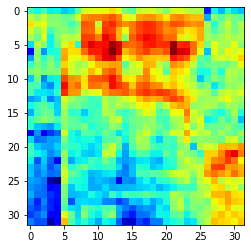

1


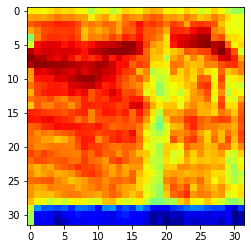

1


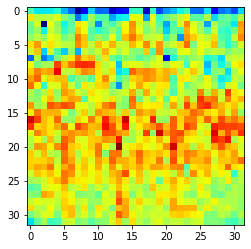

0


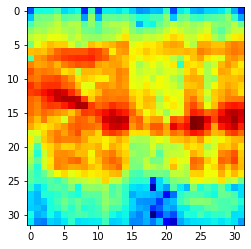

1


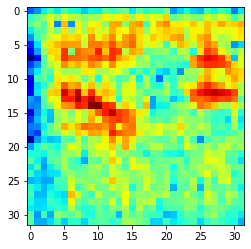

1


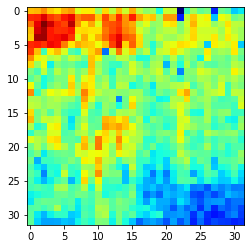

0


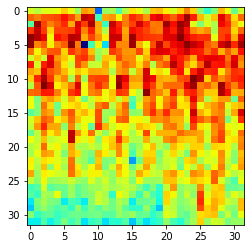

0


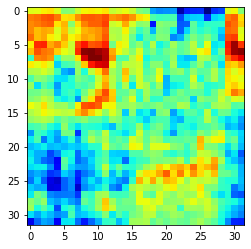

1


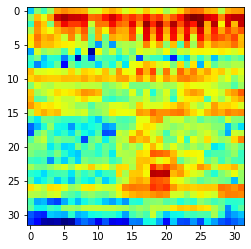

0


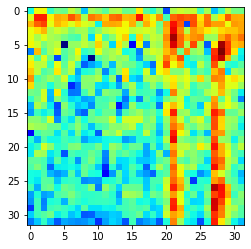

0


In [48]:
for i in range(100,110):
    visualize_spec(train_df, i)

### Вычисление параметров стандартизации данных

In [49]:
research_dataset = AVADataset(train_df, 0, 1)
research_data_loader = DataLoader(research_dataset, batch_size=32, shuffle=True, num_workers=2)

In [50]:
mean, std = get_mean_std(research_data_loader)

In [51]:
mean, std

(-3.052366018295288, 2.4621522426605225)

### Создание dataloaders для всех датасетов

In [52]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

#mean=-3.052366018295288
#std=2.4621522426605225
train_dataset = AVADataset(train_df, mean, std)
valid_dataset = AVADataset(valid_df, mean, std)
test_dataset = AVADataset(test_df, mean, std)

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_data_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f'Images for train: {train_df.shape[0]}, images for validation: {valid_df.shape[0]}, images for test: {test_df.shape[0]}')

Images for train: 159240, images for validation: 17694, images for test: 44234


### Создание модели

In [53]:
model = ModelVad()
model_wrapper = ModelWrapper(model=model)
summary(model_wrapper.model, input_size=(32, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ModelVad                                 --                        --
├─Conv2d: 1-1                            [32, 32, 28, 28]          832
├─MaxPool2d: 1-2                         [32, 32, 14, 14]          --
├─Conv2d: 1-3                            [32, 128, 12, 12]         36,992
├─MaxPool2d: 1-4                         [32, 128, 6, 6]           --
├─Linear: 1-5                            [32, 64]                  294,976
├─LSTM: 1-6                              [32, 64, 256]             134,144
├─Linear: 1-7                            [32, 2]                   514
Total params: 467,458
Trainable params: 467,458
Non-trainable params: 0
Total mult-adds (M): 475.51
Input size (MB): 0.13
Forward/backward pass size (MB): 15.35
Params size (MB): 1.87
Estimated Total Size (MB): 17.35

In [54]:
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = ExponentialLR(optimizer, gamma=0.95)
metric = metrics.roc_auc_score
criterion = torch.nn.BCELoss()

### Обучение

In [55]:
result_train = model_wrapper.fit(criterion,
             metric,
             optimizer,
             scheduler,
             train_data_loader,
             valid_data_loader,
             epochs=10,
             verbose=10)

Train Epoch: 1, Loss: 0.694981, Learning rate: 0.005
Spended time for 10 batches (total: 9)(320 images: 1.859464 sec
Train Epoch: 1, Loss: 0.647794, Learning rate: 0.005
Spended time for 10 batches (total: 19)(320 images: 1.673875 sec
Train Epoch: 1, Loss: 0.650190, Learning rate: 0.005
Spended time for 10 batches (total: 29)(320 images: 1.701295 sec
Train Epoch: 1, Loss: 0.654098, Learning rate: 0.005
Spended time for 10 batches (total: 39)(320 images: 1.619082 sec
Train Epoch: 1, Loss: 0.636588, Learning rate: 0.005
Spended time for 10 batches (total: 49)(320 images: 1.581786 sec
Train Epoch: 1, Loss: 0.642750, Learning rate: 0.005
Spended time for 10 batches (total: 59)(320 images: 1.577924 sec
Train Epoch: 1, Loss: 0.595287, Learning rate: 0.005
Spended time for 10 batches (total: 69)(320 images: 1.576453 sec
Train Epoch: 1, Loss: 0.597788, Learning rate: 0.005
Spended time for 10 batches (total: 79)(320 images: 1.586116 sec
Train Epoch: 1, Loss: 0.559825, Learning rate: 0.005
Spen

Train Epoch: 1, Loss: 0.449088, Learning rate: 0.005
Spended time for 10 batches (total: 699)(320 images: 1.613326 sec
Train Epoch: 1, Loss: 0.411027, Learning rate: 0.005
Spended time for 10 batches (total: 709)(320 images: 1.628035 sec
Train Epoch: 1, Loss: 0.442012, Learning rate: 0.005
Spended time for 10 batches (total: 719)(320 images: 1.612057 sec
Train Epoch: 1, Loss: 0.443487, Learning rate: 0.005
Spended time for 10 batches (total: 729)(320 images: 1.712475 sec
Train Epoch: 1, Loss: 0.442145, Learning rate: 0.005
Spended time for 10 batches (total: 739)(320 images: 1.819031 sec
Train Epoch: 1, Loss: 0.441735, Learning rate: 0.005
Spended time for 10 batches (total: 749)(320 images: 1.649333 sec
Train Epoch: 1, Loss: 0.447733, Learning rate: 0.005
Spended time for 10 batches (total: 759)(320 images: 1.618665 sec
Train Epoch: 1, Loss: 0.460442, Learning rate: 0.005
Spended time for 10 batches (total: 769)(320 images: 1.645969 sec
Train Epoch: 1, Loss: 0.438543, Learning rate: 0

Train Epoch: 1, Loss: 0.426126, Learning rate: 0.005
Spended time for 10 batches (total: 1389)(320 images: 1.739915 sec
Train Epoch: 1, Loss: 0.361969, Learning rate: 0.005
Spended time for 10 batches (total: 1399)(320 images: 1.742740 sec
Train Epoch: 1, Loss: 0.415846, Learning rate: 0.005
Spended time for 10 batches (total: 1409)(320 images: 1.776116 sec
Train Epoch: 1, Loss: 0.371883, Learning rate: 0.005
Spended time for 10 batches (total: 1419)(320 images: 1.843126 sec
Train Epoch: 1, Loss: 0.425330, Learning rate: 0.005
Spended time for 10 batches (total: 1429)(320 images: 2.066815 sec
Train Epoch: 1, Loss: 0.435885, Learning rate: 0.005
Spended time for 10 batches (total: 1439)(320 images: 1.630851 sec
Train Epoch: 1, Loss: 0.410045, Learning rate: 0.005
Spended time for 10 batches (total: 1449)(320 images: 1.630034 sec
Train Epoch: 1, Loss: 0.405954, Learning rate: 0.005
Spended time for 10 batches (total: 1459)(320 images: 1.623873 sec
Train Epoch: 1, Loss: 0.438290, Learning

Train Epoch: 1, Loss: 0.405884, Learning rate: 0.005
Spended time for 10 batches (total: 2079)(320 images: 1.666033 sec
Train Epoch: 1, Loss: 0.412291, Learning rate: 0.005
Spended time for 10 batches (total: 2089)(320 images: 1.661654 sec
Train Epoch: 1, Loss: 0.386956, Learning rate: 0.005
Spended time for 10 batches (total: 2099)(320 images: 1.712415 sec
Train Epoch: 1, Loss: 0.451807, Learning rate: 0.005
Spended time for 10 batches (total: 2109)(320 images: 1.682629 sec
Train Epoch: 1, Loss: 0.392231, Learning rate: 0.005
Spended time for 10 batches (total: 2119)(320 images: 1.721936 sec
Train Epoch: 1, Loss: 0.399498, Learning rate: 0.005
Spended time for 10 batches (total: 2129)(320 images: 1.736831 sec
Train Epoch: 1, Loss: 0.478323, Learning rate: 0.005
Spended time for 10 batches (total: 2139)(320 images: 1.755080 sec
Train Epoch: 1, Loss: 0.400929, Learning rate: 0.005
Spended time for 10 batches (total: 2149)(320 images: 1.748978 sec
Train Epoch: 1, Loss: 0.432278, Learning

Train Epoch: 1, Loss: 0.361897, Learning rate: 0.005
Spended time for 10 batches (total: 2769)(320 images: 1.766236 sec
Train Epoch: 1, Loss: 0.391099, Learning rate: 0.005
Spended time for 10 batches (total: 2779)(320 images: 1.815799 sec
Train Epoch: 1, Loss: 0.401337, Learning rate: 0.005
Spended time for 10 batches (total: 2789)(320 images: 1.784334 sec
Train Epoch: 1, Loss: 0.357466, Learning rate: 0.005
Spended time for 10 batches (total: 2799)(320 images: 1.814407 sec
Train Epoch: 1, Loss: 0.330602, Learning rate: 0.005
Spended time for 10 batches (total: 2809)(320 images: 1.793666 sec
Train Epoch: 1, Loss: 0.367720, Learning rate: 0.005
Spended time for 10 batches (total: 2819)(320 images: 1.693008 sec
Train Epoch: 1, Loss: 0.337677, Learning rate: 0.005
Spended time for 10 batches (total: 2829)(320 images: 1.746149 sec
Train Epoch: 1, Loss: 0.363956, Learning rate: 0.005
Spended time for 10 batches (total: 2839)(320 images: 1.783944 sec
Train Epoch: 1, Loss: 0.380858, Learning

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 1, train loss: 0.426965, valid loss: 0.390332, valid metric: 0.904531
Train Epoch: 1, Loss: 0.392296, Learning rate: 0.005
Spended time for 10 batches (total: 3009)(320 images: 44.321067 sec
Train Epoch: 1, Loss: 0.415090, Learning rate: 0.005
Spended time for 10 batches (total: 3019)(320 images: 1.847962 sec
Train Epoch: 1, Loss: 0.330858, Learning rate: 0.005
Spended time for 10 batches (total: 3029)(320 images: 1.903555 sec
Train Epoch: 1, Loss: 0.397980, Learning rate: 0.005
Spended time for 10 batches (total: 3039)(320 images: 1.898943 sec
Train Epoch: 1, Loss: 0.336021, Learning rate: 0.005
Spended time for 10 batches (total: 3049)(320 images: 2.001597 sec
Train Epoch: 1, Loss: 0.387447, Learning rate: 0.005
Spended time for 10 batches (total: 3059)(320 images: 1.918789 sec
Train Epoch: 1, Loss: 0.393433, Learning rate: 0.005
Spended time for 10 batches (total: 3069)(320 images: 1.798514 sec
Train Epoch: 1, Loss: 0.444521, Learning rate: 0.005
Spended time for 10 batches (t

Train Epoch: 1, Loss: 0.432846, Learning rate: 0.005
Spended time for 10 batches (total: 3679)(320 images: 1.846084 sec
Train Epoch: 1, Loss: 0.337592, Learning rate: 0.005
Spended time for 10 batches (total: 3689)(320 images: 1.821607 sec
Train Epoch: 1, Loss: 0.432843, Learning rate: 0.005
Spended time for 10 batches (total: 3699)(320 images: 1.734960 sec
Train Epoch: 1, Loss: 0.381851, Learning rate: 0.005
Spended time for 10 batches (total: 3709)(320 images: 2.037934 sec
Train Epoch: 1, Loss: 0.439992, Learning rate: 0.005
Spended time for 10 batches (total: 3719)(320 images: 1.951405 sec
Train Epoch: 1, Loss: 0.408600, Learning rate: 0.005
Spended time for 10 batches (total: 3729)(320 images: 2.771620 sec
Train Epoch: 1, Loss: 0.345890, Learning rate: 0.005
Spended time for 10 batches (total: 3739)(320 images: 2.710601 sec
Train Epoch: 1, Loss: 0.428962, Learning rate: 0.005
Spended time for 10 batches (total: 3749)(320 images: 2.526430 sec
Train Epoch: 1, Loss: 0.393511, Learning

Train Epoch: 1, Loss: 0.360058, Learning rate: 0.005
Spended time for 10 batches (total: 4369)(320 images: 1.979429 sec
Train Epoch: 1, Loss: 0.352383, Learning rate: 0.005
Spended time for 10 batches (total: 4379)(320 images: 2.024688 sec
Train Epoch: 1, Loss: 0.295162, Learning rate: 0.005
Spended time for 10 batches (total: 4389)(320 images: 1.995006 sec
Train Epoch: 1, Loss: 0.455292, Learning rate: 0.005
Spended time for 10 batches (total: 4399)(320 images: 1.930490 sec
Train Epoch: 1, Loss: 0.438753, Learning rate: 0.005
Spended time for 10 batches (total: 4409)(320 images: 1.980205 sec
Train Epoch: 1, Loss: 0.402225, Learning rate: 0.005
Spended time for 10 batches (total: 4419)(320 images: 1.977607 sec
Train Epoch: 1, Loss: 0.353518, Learning rate: 0.005
Spended time for 10 batches (total: 4429)(320 images: 2.167110 sec
Train Epoch: 1, Loss: 0.354810, Learning rate: 0.005
Spended time for 10 batches (total: 4439)(320 images: 2.071882 sec
Train Epoch: 1, Loss: 0.383731, Learning

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 2, Loss: 0.361865, Learning rate: 0.00475
Spended time for 10 batches (total: 9)(320 images: 2.848284 sec
Train Epoch: 2, Loss: 0.403789, Learning rate: 0.00475
Spended time for 10 batches (total: 19)(320 images: 2.259118 sec
Train Epoch: 2, Loss: 0.414734, Learning rate: 0.00475
Spended time for 10 batches (total: 29)(320 images: 2.209018 sec
Train Epoch: 2, Loss: 0.351938, Learning rate: 0.00475
Spended time for 10 batches (total: 39)(320 images: 2.895181 sec
Train Epoch: 2, Loss: 0.375412, Learning rate: 0.00475
Spended time for 10 batches (total: 49)(320 images: 2.588069 sec
Train Epoch: 2, Loss: 0.404424, Learning rate: 0.00475
Spended time for 10 batches (total: 59)(320 images: 2.042624 sec
Train Epoch: 2, Loss: 0.340464, Learning rate: 0.00475
Spended time for 10 batches (total: 69)(320 images: 2.092663 sec
Train Epoch: 2, Loss: 0.348765, Learning rate: 0.00475
Spended time for 10 batches (total: 79)(320 images: 2.129455 sec
Train Epoch: 2, Loss: 0.404483, Learning 

Train Epoch: 2, Loss: 0.370612, Learning rate: 0.00475
Spended time for 10 batches (total: 689)(320 images: 1.976027 sec
Train Epoch: 2, Loss: 0.387514, Learning rate: 0.00475
Spended time for 10 batches (total: 699)(320 images: 1.878388 sec
Train Epoch: 2, Loss: 0.379864, Learning rate: 0.00475
Spended time for 10 batches (total: 709)(320 images: 1.970098 sec
Train Epoch: 2, Loss: 0.305536, Learning rate: 0.00475
Spended time for 10 batches (total: 719)(320 images: 1.922907 sec
Train Epoch: 2, Loss: 0.367713, Learning rate: 0.00475
Spended time for 10 batches (total: 729)(320 images: 1.960699 sec
Train Epoch: 2, Loss: 0.316218, Learning rate: 0.00475
Spended time for 10 batches (total: 739)(320 images: 1.954953 sec
Train Epoch: 2, Loss: 0.353619, Learning rate: 0.00475
Spended time for 10 batches (total: 749)(320 images: 1.867180 sec
Train Epoch: 2, Loss: 0.364807, Learning rate: 0.00475
Spended time for 10 batches (total: 759)(320 images: 1.957535 sec
Train Epoch: 2, Loss: 0.395842, 

Train Epoch: 2, Loss: 0.335863, Learning rate: 0.00475
Spended time for 10 batches (total: 1369)(320 images: 2.112616 sec
Train Epoch: 2, Loss: 0.324470, Learning rate: 0.00475
Spended time for 10 batches (total: 1379)(320 images: 2.064512 sec
Train Epoch: 2, Loss: 0.356753, Learning rate: 0.00475
Spended time for 10 batches (total: 1389)(320 images: 2.178690 sec
Train Epoch: 2, Loss: 0.384750, Learning rate: 0.00475
Spended time for 10 batches (total: 1399)(320 images: 2.147607 sec
Train Epoch: 2, Loss: 0.355409, Learning rate: 0.00475
Spended time for 10 batches (total: 1409)(320 images: 1.996900 sec
Train Epoch: 2, Loss: 0.416776, Learning rate: 0.00475
Spended time for 10 batches (total: 1419)(320 images: 2.047998 sec
Train Epoch: 2, Loss: 0.405871, Learning rate: 0.00475
Spended time for 10 batches (total: 1429)(320 images: 2.096086 sec
Train Epoch: 2, Loss: 0.322478, Learning rate: 0.00475
Spended time for 10 batches (total: 1439)(320 images: 2.190187 sec
Train Epoch: 2, Loss: 0.

Train Epoch: 2, Loss: 0.372618, Learning rate: 0.00475
Spended time for 10 batches (total: 2049)(320 images: 2.498533 sec
Train Epoch: 2, Loss: 0.335612, Learning rate: 0.00475
Spended time for 10 batches (total: 2059)(320 images: 2.545632 sec
Train Epoch: 2, Loss: 0.361104, Learning rate: 0.00475
Spended time for 10 batches (total: 2069)(320 images: 2.413304 sec
Train Epoch: 2, Loss: 0.403064, Learning rate: 0.00475
Spended time for 10 batches (total: 2079)(320 images: 2.309514 sec
Train Epoch: 2, Loss: 0.362251, Learning rate: 0.00475
Spended time for 10 batches (total: 2089)(320 images: 2.293119 sec
Train Epoch: 2, Loss: 0.378698, Learning rate: 0.00475
Spended time for 10 batches (total: 2099)(320 images: 2.336031 sec
Train Epoch: 2, Loss: 0.343675, Learning rate: 0.00475
Spended time for 10 batches (total: 2109)(320 images: 2.292223 sec
Train Epoch: 2, Loss: 0.332764, Learning rate: 0.00475
Spended time for 10 batches (total: 2119)(320 images: 2.505460 sec
Train Epoch: 2, Loss: 0.

Train Epoch: 2, Loss: 0.357084, Learning rate: 0.00475
Spended time for 10 batches (total: 2729)(320 images: 2.394774 sec
Train Epoch: 2, Loss: 0.359231, Learning rate: 0.00475
Spended time for 10 batches (total: 2739)(320 images: 2.386564 sec
Train Epoch: 2, Loss: 0.323098, Learning rate: 0.00475
Spended time for 10 batches (total: 2749)(320 images: 2.527736 sec
Train Epoch: 2, Loss: 0.385322, Learning rate: 0.00475
Spended time for 10 batches (total: 2759)(320 images: 2.404037 sec
Train Epoch: 2, Loss: 0.353659, Learning rate: 0.00475
Spended time for 10 batches (total: 2769)(320 images: 2.233129 sec
Train Epoch: 2, Loss: 0.352612, Learning rate: 0.00475
Spended time for 10 batches (total: 2779)(320 images: 2.384156 sec
Train Epoch: 2, Loss: 0.360140, Learning rate: 0.00475
Spended time for 10 batches (total: 2789)(320 images: 2.273589 sec
Train Epoch: 2, Loss: 0.373786, Learning rate: 0.00475
Spended time for 10 batches (total: 2799)(320 images: 2.355439 sec
Train Epoch: 2, Loss: 0.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 2, train loss: 0.367638, valid loss: 0.361092, valid metric: 0.911924
Train Epoch: 2, Loss: 0.406819, Learning rate: 0.00475
Spended time for 10 batches (total: 3009)(320 images: 47.127274 sec
Train Epoch: 2, Loss: 0.387611, Learning rate: 0.00475
Spended time for 10 batches (total: 3019)(320 images: 2.351792 sec
Train Epoch: 2, Loss: 0.348414, Learning rate: 0.00475
Spended time for 10 batches (total: 3029)(320 images: 2.556001 sec
Train Epoch: 2, Loss: 0.372472, Learning rate: 0.00475
Spended time for 10 batches (total: 3039)(320 images: 2.381657 sec
Train Epoch: 2, Loss: 0.395293, Learning rate: 0.00475
Spended time for 10 batches (total: 3049)(320 images: 2.457703 sec
Train Epoch: 2, Loss: 0.364080, Learning rate: 0.00475
Spended time for 10 batches (total: 3059)(320 images: 2.202029 sec
Train Epoch: 2, Loss: 0.328854, Learning rate: 0.00475
Spended time for 10 batches (total: 3069)(320 images: 2.397987 sec
Train Epoch: 2, Loss: 0.382118, Learning rate: 0.00475
Spended time f

Train Epoch: 2, Loss: 0.296632, Learning rate: 0.00475
Spended time for 10 batches (total: 3669)(320 images: 2.815914 sec
Train Epoch: 2, Loss: 0.391317, Learning rate: 0.00475
Spended time for 10 batches (total: 3679)(320 images: 3.650779 sec
Train Epoch: 2, Loss: 0.348017, Learning rate: 0.00475
Spended time for 10 batches (total: 3689)(320 images: 2.609307 sec
Train Epoch: 2, Loss: 0.388637, Learning rate: 0.00475
Spended time for 10 batches (total: 3699)(320 images: 2.682373 sec
Train Epoch: 2, Loss: 0.327589, Learning rate: 0.00475
Spended time for 10 batches (total: 3709)(320 images: 2.643888 sec
Train Epoch: 2, Loss: 0.367358, Learning rate: 0.00475
Spended time for 10 batches (total: 3719)(320 images: 2.495779 sec
Train Epoch: 2, Loss: 0.366679, Learning rate: 0.00475
Spended time for 10 batches (total: 3729)(320 images: 2.515850 sec
Train Epoch: 2, Loss: 0.365373, Learning rate: 0.00475
Spended time for 10 batches (total: 3739)(320 images: 2.578906 sec
Train Epoch: 2, Loss: 0.

Train Epoch: 2, Loss: 0.383155, Learning rate: 0.00475
Spended time for 10 batches (total: 4349)(320 images: 3.784247 sec
Train Epoch: 2, Loss: 0.367968, Learning rate: 0.00475
Spended time for 10 batches (total: 4359)(320 images: 3.562422 sec
Train Epoch: 2, Loss: 0.323917, Learning rate: 0.00475
Spended time for 10 batches (total: 4369)(320 images: 3.704955 sec
Train Epoch: 2, Loss: 0.394924, Learning rate: 0.00475
Spended time for 10 batches (total: 4379)(320 images: 3.488482 sec
Train Epoch: 2, Loss: 0.340136, Learning rate: 0.00475
Spended time for 10 batches (total: 4389)(320 images: 3.702196 sec
Train Epoch: 2, Loss: 0.319896, Learning rate: 0.00475
Spended time for 10 batches (total: 4399)(320 images: 4.558356 sec
Train Epoch: 2, Loss: 0.370842, Learning rate: 0.00475
Spended time for 10 batches (total: 4409)(320 images: 3.861907 sec
Train Epoch: 2, Loss: 0.402770, Learning rate: 0.00475
Spended time for 10 batches (total: 4419)(320 images: 3.835308 sec
Train Epoch: 2, Loss: 0.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 3, Loss: 0.356062, Learning rate: 0.0045125
Spended time for 10 batches (total: 9)(320 images: 3.167417 sec
Train Epoch: 3, Loss: 0.357154, Learning rate: 0.0045125
Spended time for 10 batches (total: 19)(320 images: 2.865922 sec
Train Epoch: 3, Loss: 0.389685, Learning rate: 0.0045125
Spended time for 10 batches (total: 29)(320 images: 2.992767 sec
Train Epoch: 3, Loss: 0.371365, Learning rate: 0.0045125
Spended time for 10 batches (total: 39)(320 images: 3.121115 sec
Train Epoch: 3, Loss: 0.361331, Learning rate: 0.0045125
Spended time for 10 batches (total: 49)(320 images: 3.491005 sec
Train Epoch: 3, Loss: 0.352929, Learning rate: 0.0045125
Spended time for 10 batches (total: 59)(320 images: 3.906071 sec
Train Epoch: 3, Loss: 0.315254, Learning rate: 0.0045125
Spended time for 10 batches (total: 69)(320 images: 4.291037 sec
Train Epoch: 3, Loss: 0.372706, Learning rate: 0.0045125
Spended time for 10 batches (total: 79)(320 images: 3.641093 sec
Train Epoch: 3, Loss: 0.3

Train Epoch: 3, Loss: 0.404887, Learning rate: 0.0045125
Spended time for 10 batches (total: 679)(320 images: 3.315900 sec
Train Epoch: 3, Loss: 0.342453, Learning rate: 0.0045125
Spended time for 10 batches (total: 689)(320 images: 3.229301 sec
Train Epoch: 3, Loss: 0.340104, Learning rate: 0.0045125
Spended time for 10 batches (total: 699)(320 images: 3.731867 sec
Train Epoch: 3, Loss: 0.358846, Learning rate: 0.0045125
Spended time for 10 batches (total: 709)(320 images: 3.253797 sec
Train Epoch: 3, Loss: 0.413088, Learning rate: 0.0045125
Spended time for 10 batches (total: 719)(320 images: 2.929621 sec
Train Epoch: 3, Loss: 0.374191, Learning rate: 0.0045125
Spended time for 10 batches (total: 729)(320 images: 3.272741 sec
Train Epoch: 3, Loss: 0.363228, Learning rate: 0.0045125
Spended time for 10 batches (total: 739)(320 images: 2.864685 sec
Train Epoch: 3, Loss: 0.330354, Learning rate: 0.0045125
Spended time for 10 batches (total: 749)(320 images: 2.880374 sec
Train Epoch: 3, 

Train Epoch: 3, Loss: 0.360417, Learning rate: 0.0045125
Spended time for 10 batches (total: 1349)(320 images: 3.664462 sec
Train Epoch: 3, Loss: 0.362198, Learning rate: 0.0045125
Spended time for 10 batches (total: 1359)(320 images: 3.310533 sec
Train Epoch: 3, Loss: 0.267268, Learning rate: 0.0045125
Spended time for 10 batches (total: 1369)(320 images: 3.332901 sec
Train Epoch: 3, Loss: 0.354313, Learning rate: 0.0045125
Spended time for 10 batches (total: 1379)(320 images: 3.286384 sec
Train Epoch: 3, Loss: 0.335773, Learning rate: 0.0045125
Spended time for 10 batches (total: 1389)(320 images: 3.611581 sec
Train Epoch: 3, Loss: 0.404173, Learning rate: 0.0045125
Spended time for 10 batches (total: 1399)(320 images: 4.257036 sec
Train Epoch: 3, Loss: 0.365401, Learning rate: 0.0045125
Spended time for 10 batches (total: 1409)(320 images: 4.178919 sec
Train Epoch: 3, Loss: 0.393479, Learning rate: 0.0045125
Spended time for 10 batches (total: 1419)(320 images: 4.025251 sec
Train Ep

Train Epoch: 3, Loss: 0.339859, Learning rate: 0.0045125
Spended time for 10 batches (total: 2019)(320 images: 3.548955 sec
Train Epoch: 3, Loss: 0.384922, Learning rate: 0.0045125
Spended time for 10 batches (total: 2029)(320 images: 3.522719 sec
Train Epoch: 3, Loss: 0.268875, Learning rate: 0.0045125
Spended time for 10 batches (total: 2039)(320 images: 3.750654 sec
Train Epoch: 3, Loss: 0.340016, Learning rate: 0.0045125
Spended time for 10 batches (total: 2049)(320 images: 3.447275 sec
Train Epoch: 3, Loss: 0.344974, Learning rate: 0.0045125
Spended time for 10 batches (total: 2059)(320 images: 3.425717 sec
Train Epoch: 3, Loss: 0.394249, Learning rate: 0.0045125
Spended time for 10 batches (total: 2069)(320 images: 3.536533 sec
Train Epoch: 3, Loss: 0.397071, Learning rate: 0.0045125
Spended time for 10 batches (total: 2079)(320 images: 3.673339 sec
Train Epoch: 3, Loss: 0.355143, Learning rate: 0.0045125
Spended time for 10 batches (total: 2089)(320 images: 3.450430 sec
Train Ep

Train Epoch: 3, Loss: 0.347897, Learning rate: 0.0045125
Spended time for 10 batches (total: 2689)(320 images: 3.735569 sec
Train Epoch: 3, Loss: 0.407839, Learning rate: 0.0045125
Spended time for 10 batches (total: 2699)(320 images: 3.628544 sec
Train Epoch: 3, Loss: 0.405348, Learning rate: 0.0045125
Spended time for 10 batches (total: 2709)(320 images: 3.705945 sec
Train Epoch: 3, Loss: 0.396584, Learning rate: 0.0045125
Spended time for 10 batches (total: 2719)(320 images: 3.596680 sec
Train Epoch: 3, Loss: 0.365591, Learning rate: 0.0045125
Spended time for 10 batches (total: 2729)(320 images: 3.740821 sec
Train Epoch: 3, Loss: 0.359533, Learning rate: 0.0045125
Spended time for 10 batches (total: 2739)(320 images: 3.579192 sec
Train Epoch: 3, Loss: 0.389426, Learning rate: 0.0045125
Spended time for 10 batches (total: 2749)(320 images: 3.763667 sec
Train Epoch: 3, Loss: 0.345041, Learning rate: 0.0045125
Spended time for 10 batches (total: 2759)(320 images: 3.865749 sec
Train Ep

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 3, train loss: 0.357045, valid loss: 0.380996, valid metric: 0.914590
Train Epoch: 3, Loss: 0.304039, Learning rate: 0.0045125
Spended time for 10 batches (total: 3009)(320 images: 55.771517 sec
Train Epoch: 3, Loss: 0.397222, Learning rate: 0.0045125
Spended time for 10 batches (total: 3019)(320 images: 3.551382 sec
Train Epoch: 3, Loss: 0.382113, Learning rate: 0.0045125
Spended time for 10 batches (total: 3029)(320 images: 3.316655 sec
Train Epoch: 3, Loss: 0.361662, Learning rate: 0.0045125
Spended time for 10 batches (total: 3039)(320 images: 3.597094 sec
Train Epoch: 3, Loss: 0.401238, Learning rate: 0.0045125
Spended time for 10 batches (total: 3049)(320 images: 3.399327 sec
Train Epoch: 3, Loss: 0.390666, Learning rate: 0.0045125
Spended time for 10 batches (total: 3059)(320 images: 3.424428 sec
Train Epoch: 3, Loss: 0.356911, Learning rate: 0.0045125
Spended time for 10 batches (total: 3069)(320 images: 3.579341 sec
Train Epoch: 3, Loss: 0.344566, Learning rate: 0.004512

Train Epoch: 3, Loss: 0.369744, Learning rate: 0.0045125
Spended time for 10 batches (total: 3659)(320 images: 3.813906 sec
Train Epoch: 3, Loss: 0.345713, Learning rate: 0.0045125
Spended time for 10 batches (total: 3669)(320 images: 3.421815 sec
Train Epoch: 3, Loss: 0.345893, Learning rate: 0.0045125
Spended time for 10 batches (total: 3679)(320 images: 3.557853 sec
Train Epoch: 3, Loss: 0.390556, Learning rate: 0.0045125
Spended time for 10 batches (total: 3689)(320 images: 3.838324 sec
Train Epoch: 3, Loss: 0.294119, Learning rate: 0.0045125
Spended time for 10 batches (total: 3699)(320 images: 3.587488 sec
Train Epoch: 3, Loss: 0.362638, Learning rate: 0.0045125
Spended time for 10 batches (total: 3709)(320 images: 3.496576 sec
Train Epoch: 3, Loss: 0.336520, Learning rate: 0.0045125
Spended time for 10 batches (total: 3719)(320 images: 3.661482 sec
Train Epoch: 3, Loss: 0.390234, Learning rate: 0.0045125
Spended time for 10 batches (total: 3729)(320 images: 3.440708 sec
Train Ep

Train Epoch: 3, Loss: 0.327117, Learning rate: 0.0045125
Spended time for 10 batches (total: 4329)(320 images: 3.883235 sec
Train Epoch: 3, Loss: 0.335479, Learning rate: 0.0045125
Spended time for 10 batches (total: 4339)(320 images: 3.922169 sec
Train Epoch: 3, Loss: 0.375366, Learning rate: 0.0045125
Spended time for 10 batches (total: 4349)(320 images: 3.814156 sec
Train Epoch: 3, Loss: 0.337216, Learning rate: 0.0045125
Spended time for 10 batches (total: 4359)(320 images: 3.654370 sec
Train Epoch: 3, Loss: 0.381709, Learning rate: 0.0045125
Spended time for 10 batches (total: 4369)(320 images: 3.746349 sec
Train Epoch: 3, Loss: 0.380036, Learning rate: 0.0045125
Spended time for 10 batches (total: 4379)(320 images: 3.503301 sec
Train Epoch: 3, Loss: 0.318893, Learning rate: 0.0045125
Spended time for 10 batches (total: 4389)(320 images: 3.622450 sec
Train Epoch: 3, Loss: 0.315995, Learning rate: 0.0045125
Spended time for 10 batches (total: 4399)(320 images: 3.681220 sec
Train Ep

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 4, Loss: 0.406937, Learning rate: 0.004286875
Spended time for 10 batches (total: 9)(320 images: 4.201159 sec
Train Epoch: 4, Loss: 0.364862, Learning rate: 0.004286875
Spended time for 10 batches (total: 19)(320 images: 3.928002 sec
Train Epoch: 4, Loss: 0.368781, Learning rate: 0.004286875
Spended time for 10 batches (total: 29)(320 images: 4.064384 sec
Train Epoch: 4, Loss: 0.427819, Learning rate: 0.004286875
Spended time for 10 batches (total: 39)(320 images: 3.815936 sec
Train Epoch: 4, Loss: 0.397630, Learning rate: 0.004286875
Spended time for 10 batches (total: 49)(320 images: 4.060252 sec
Train Epoch: 4, Loss: 0.354945, Learning rate: 0.004286875
Spended time for 10 batches (total: 59)(320 images: 4.373981 sec
Train Epoch: 4, Loss: 0.374914, Learning rate: 0.004286875
Spended time for 10 batches (total: 69)(320 images: 4.204346 sec
Train Epoch: 4, Loss: 0.336029, Learning rate: 0.004286875
Spended time for 10 batches (total: 79)(320 images: 4.278156 sec
Train Epo

Train Epoch: 4, Loss: 0.331965, Learning rate: 0.004286875
Spended time for 10 batches (total: 669)(320 images: 3.841599 sec
Train Epoch: 4, Loss: 0.414337, Learning rate: 0.004286875
Spended time for 10 batches (total: 679)(320 images: 3.896612 sec
Train Epoch: 4, Loss: 0.339935, Learning rate: 0.004286875
Spended time for 10 batches (total: 689)(320 images: 3.967577 sec
Train Epoch: 4, Loss: 0.346135, Learning rate: 0.004286875
Spended time for 10 batches (total: 699)(320 images: 3.781537 sec
Train Epoch: 4, Loss: 0.318589, Learning rate: 0.004286875
Spended time for 10 batches (total: 709)(320 images: 3.785119 sec
Train Epoch: 4, Loss: 0.329531, Learning rate: 0.004286875
Spended time for 10 batches (total: 719)(320 images: 3.980315 sec
Train Epoch: 4, Loss: 0.403265, Learning rate: 0.004286875
Spended time for 10 batches (total: 729)(320 images: 3.863213 sec
Train Epoch: 4, Loss: 0.347139, Learning rate: 0.004286875
Spended time for 10 batches (total: 739)(320 images: 3.910942 sec


Train Epoch: 4, Loss: 0.366688, Learning rate: 0.004286875
Spended time for 10 batches (total: 1329)(320 images: 3.980340 sec
Train Epoch: 4, Loss: 0.302926, Learning rate: 0.004286875
Spended time for 10 batches (total: 1339)(320 images: 4.242362 sec
Train Epoch: 4, Loss: 0.364362, Learning rate: 0.004286875
Spended time for 10 batches (total: 1349)(320 images: 3.847554 sec
Train Epoch: 4, Loss: 0.337471, Learning rate: 0.004286875
Spended time for 10 batches (total: 1359)(320 images: 4.012577 sec
Train Epoch: 4, Loss: 0.390785, Learning rate: 0.004286875
Spended time for 10 batches (total: 1369)(320 images: 3.656652 sec
Train Epoch: 4, Loss: 0.366393, Learning rate: 0.004286875
Spended time for 10 batches (total: 1379)(320 images: 3.927261 sec
Train Epoch: 4, Loss: 0.355223, Learning rate: 0.004286875
Spended time for 10 batches (total: 1389)(320 images: 3.929502 sec
Train Epoch: 4, Loss: 0.374769, Learning rate: 0.004286875
Spended time for 10 batches (total: 1399)(320 images: 3.971

Train Epoch: 4, Loss: 0.319057, Learning rate: 0.004286875
Spended time for 10 batches (total: 1989)(320 images: 4.089018 sec
Train Epoch: 4, Loss: 0.264283, Learning rate: 0.004286875
Spended time for 10 batches (total: 1999)(320 images: 4.059873 sec
Train Epoch: 4, Loss: 0.357778, Learning rate: 0.004286875
Spended time for 10 batches (total: 2009)(320 images: 3.858166 sec
Train Epoch: 4, Loss: 0.378670, Learning rate: 0.004286875
Spended time for 10 batches (total: 2019)(320 images: 3.900707 sec
Train Epoch: 4, Loss: 0.374962, Learning rate: 0.004286875
Spended time for 10 batches (total: 2029)(320 images: 4.013755 sec
Train Epoch: 4, Loss: 0.332750, Learning rate: 0.004286875
Spended time for 10 batches (total: 2039)(320 images: 3.953183 sec
Train Epoch: 4, Loss: 0.312935, Learning rate: 0.004286875
Spended time for 10 batches (total: 2049)(320 images: 3.867823 sec
Train Epoch: 4, Loss: 0.338826, Learning rate: 0.004286875
Spended time for 10 batches (total: 2059)(320 images: 3.788

Train Epoch: 4, Loss: 0.367054, Learning rate: 0.004286875
Spended time for 10 batches (total: 2649)(320 images: 4.476393 sec
Train Epoch: 4, Loss: 0.342058, Learning rate: 0.004286875
Spended time for 10 batches (total: 2659)(320 images: 4.524174 sec
Train Epoch: 4, Loss: 0.389496, Learning rate: 0.004286875
Spended time for 10 batches (total: 2669)(320 images: 5.233508 sec
Train Epoch: 4, Loss: 0.367279, Learning rate: 0.004286875
Spended time for 10 batches (total: 2679)(320 images: 4.721683 sec
Train Epoch: 4, Loss: 0.341809, Learning rate: 0.004286875
Spended time for 10 batches (total: 2689)(320 images: 4.788346 sec
Train Epoch: 4, Loss: 0.338260, Learning rate: 0.004286875
Spended time for 10 batches (total: 2699)(320 images: 4.702939 sec
Train Epoch: 4, Loss: 0.370013, Learning rate: 0.004286875
Spended time for 10 batches (total: 2709)(320 images: 4.588134 sec
Train Epoch: 4, Loss: 0.310558, Learning rate: 0.004286875
Spended time for 10 batches (total: 2719)(320 images: 4.713

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 4, train loss: 0.353888, valid loss: 0.345639, valid metric: 0.920384
Train Epoch: 4, Loss: 0.288423, Learning rate: 0.004286875
Spended time for 10 batches (total: 3009)(320 images: 78.517668 sec
Train Epoch: 4, Loss: 0.385883, Learning rate: 0.004286875
Spended time for 10 batches (total: 3019)(320 images: 4.753077 sec
Train Epoch: 4, Loss: 0.360515, Learning rate: 0.004286875
Spended time for 10 batches (total: 3029)(320 images: 5.165923 sec
Train Epoch: 4, Loss: 0.344156, Learning rate: 0.004286875
Spended time for 10 batches (total: 3039)(320 images: 4.980964 sec
Train Epoch: 4, Loss: 0.382564, Learning rate: 0.004286875
Spended time for 10 batches (total: 3049)(320 images: 5.011088 sec
Train Epoch: 4, Loss: 0.372292, Learning rate: 0.004286875
Spended time for 10 batches (total: 3059)(320 images: 4.889896 sec
Train Epoch: 4, Loss: 0.370541, Learning rate: 0.004286875
Spended time for 10 batches (total: 3069)(320 images: 4.904771 sec
Train Epoch: 4, Loss: 0.310119, Learning 

Train Epoch: 4, Loss: 0.350219, Learning rate: 0.004286875
Spended time for 10 batches (total: 3649)(320 images: 4.756302 sec
Train Epoch: 4, Loss: 0.376754, Learning rate: 0.004286875
Spended time for 10 batches (total: 3659)(320 images: 4.947692 sec
Train Epoch: 4, Loss: 0.303145, Learning rate: 0.004286875
Spended time for 10 batches (total: 3669)(320 images: 4.956340 sec
Train Epoch: 4, Loss: 0.375558, Learning rate: 0.004286875
Spended time for 10 batches (total: 3679)(320 images: 4.920657 sec
Train Epoch: 4, Loss: 0.372619, Learning rate: 0.004286875
Spended time for 10 batches (total: 3689)(320 images: 4.974815 sec
Train Epoch: 4, Loss: 0.366078, Learning rate: 0.004286875
Spended time for 10 batches (total: 3699)(320 images: 4.954626 sec
Train Epoch: 4, Loss: 0.386014, Learning rate: 0.004286875
Spended time for 10 batches (total: 3709)(320 images: 5.597615 sec
Train Epoch: 4, Loss: 0.296714, Learning rate: 0.004286875
Spended time for 10 batches (total: 3719)(320 images: 5.209

Train Epoch: 4, Loss: 0.406554, Learning rate: 0.004286875
Spended time for 10 batches (total: 4309)(320 images: 5.074713 sec
Train Epoch: 4, Loss: 0.370310, Learning rate: 0.004286875
Spended time for 10 batches (total: 4319)(320 images: 4.916093 sec
Train Epoch: 4, Loss: 0.309705, Learning rate: 0.004286875
Spended time for 10 batches (total: 4329)(320 images: 5.162891 sec
Train Epoch: 4, Loss: 0.331849, Learning rate: 0.004286875
Spended time for 10 batches (total: 4339)(320 images: 4.770244 sec
Train Epoch: 4, Loss: 0.366459, Learning rate: 0.004286875
Spended time for 10 batches (total: 4349)(320 images: 4.817894 sec
Train Epoch: 4, Loss: 0.346980, Learning rate: 0.004286875
Spended time for 10 batches (total: 4359)(320 images: 5.076306 sec
Train Epoch: 4, Loss: 0.354261, Learning rate: 0.004286875
Spended time for 10 batches (total: 4369)(320 images: 4.959797 sec
Train Epoch: 4, Loss: 0.388034, Learning rate: 0.004286875
Spended time for 10 batches (total: 4379)(320 images: 5.047

Train Epoch: 4, Loss: 0.351851, Learning rate: 0.004286875
Spended time for 10 batches (total: 4969)(320 images: 5.018767 sec
Epoch 4, train loss: 0.352768, valid loss: 0.390866, valid metric: 0.917094


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 5, Loss: 0.386738, Learning rate: 0.00407253125
Spended time for 10 batches (total: 9)(320 images: 5.073192 sec
Train Epoch: 5, Loss: 0.377152, Learning rate: 0.00407253125
Spended time for 10 batches (total: 19)(320 images: 4.859665 sec
Train Epoch: 5, Loss: 0.357816, Learning rate: 0.00407253125
Spended time for 10 batches (total: 29)(320 images: 4.973657 sec
Train Epoch: 5, Loss: 0.381018, Learning rate: 0.00407253125
Spended time for 10 batches (total: 39)(320 images: 5.068006 sec
Train Epoch: 5, Loss: 0.344878, Learning rate: 0.00407253125
Spended time for 10 batches (total: 49)(320 images: 4.829353 sec
Train Epoch: 5, Loss: 0.365030, Learning rate: 0.00407253125
Spended time for 10 batches (total: 59)(320 images: 4.875596 sec
Train Epoch: 5, Loss: 0.323009, Learning rate: 0.00407253125
Spended time for 10 batches (total: 69)(320 images: 5.314238 sec
Train Epoch: 5, Loss: 0.367258, Learning rate: 0.00407253125
Spended time for 10 batches (total: 79)(320 images: 4.9021

Train Epoch: 5, Loss: 0.396955, Learning rate: 0.00407253125
Spended time for 10 batches (total: 659)(320 images: 5.299265 sec
Train Epoch: 5, Loss: 0.331718, Learning rate: 0.00407253125
Spended time for 10 batches (total: 669)(320 images: 5.205441 sec
Train Epoch: 5, Loss: 0.363526, Learning rate: 0.00407253125
Spended time for 10 batches (total: 679)(320 images: 5.222319 sec
Train Epoch: 5, Loss: 0.325528, Learning rate: 0.00407253125
Spended time for 10 batches (total: 689)(320 images: 5.183647 sec
Train Epoch: 5, Loss: 0.365619, Learning rate: 0.00407253125
Spended time for 10 batches (total: 699)(320 images: 4.972495 sec
Train Epoch: 5, Loss: 0.336924, Learning rate: 0.00407253125
Spended time for 10 batches (total: 709)(320 images: 5.140590 sec
Train Epoch: 5, Loss: 0.314134, Learning rate: 0.00407253125
Spended time for 10 batches (total: 719)(320 images: 5.015092 sec
Train Epoch: 5, Loss: 0.322147, Learning rate: 0.00407253125
Spended time for 10 batches (total: 729)(320 image

Train Epoch: 5, Loss: 0.363292, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1309)(320 images: 5.300700 sec
Train Epoch: 5, Loss: 0.284578, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1319)(320 images: 5.390848 sec
Train Epoch: 5, Loss: 0.333920, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1329)(320 images: 5.367439 sec
Train Epoch: 5, Loss: 0.326097, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1339)(320 images: 5.120991 sec
Train Epoch: 5, Loss: 0.361724, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1349)(320 images: 5.314636 sec
Train Epoch: 5, Loss: 0.319832, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1359)(320 images: 5.545283 sec
Train Epoch: 5, Loss: 0.344450, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1369)(320 images: 5.473297 sec
Train Epoch: 5, Loss: 0.352672, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1379)(3

Train Epoch: 5, Loss: 0.344578, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1959)(320 images: 5.619223 sec
Train Epoch: 5, Loss: 0.319025, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1969)(320 images: 5.720949 sec
Train Epoch: 5, Loss: 0.317115, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1979)(320 images: 5.432014 sec
Train Epoch: 5, Loss: 0.343558, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1989)(320 images: 5.456867 sec
Train Epoch: 5, Loss: 0.340314, Learning rate: 0.00407253125
Spended time for 10 batches (total: 1999)(320 images: 5.466631 sec
Train Epoch: 5, Loss: 0.351989, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2009)(320 images: 5.800048 sec
Train Epoch: 5, Loss: 0.304396, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2019)(320 images: 5.665531 sec
Train Epoch: 5, Loss: 0.382498, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2029)(3

Train Epoch: 5, Loss: 0.400286, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2609)(320 images: 5.425323 sec
Train Epoch: 5, Loss: 0.370475, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2619)(320 images: 5.635904 sec
Train Epoch: 5, Loss: 0.442791, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2629)(320 images: 5.722041 sec
Train Epoch: 5, Loss: 0.318156, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2639)(320 images: 5.978668 sec
Train Epoch: 5, Loss: 0.370408, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2649)(320 images: 6.006039 sec
Train Epoch: 5, Loss: 0.351379, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2659)(320 images: 5.825292 sec
Train Epoch: 5, Loss: 0.369917, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2669)(320 images: 5.563098 sec
Train Epoch: 5, Loss: 0.314944, Learning rate: 0.00407253125
Spended time for 10 batches (total: 2679)(3

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 5, train loss: 0.348401, valid loss: 0.358101, valid metric: 0.914019
Train Epoch: 5, Loss: 0.329263, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3009)(320 images: 85.523976 sec
Train Epoch: 5, Loss: 0.343671, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3019)(320 images: 5.457052 sec
Train Epoch: 5, Loss: 0.372170, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3029)(320 images: 5.213369 sec
Train Epoch: 5, Loss: 0.383933, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3039)(320 images: 5.200908 sec
Train Epoch: 5, Loss: 0.366758, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3049)(320 images: 5.202130 sec
Train Epoch: 5, Loss: 0.361081, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3059)(320 images: 5.502231 sec
Train Epoch: 5, Loss: 0.341396, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3069)(320 images: 5.418260 sec
Train Epoch: 5, Loss: 0.364

Train Epoch: 5, Loss: 0.327155, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3639)(320 images: 5.899899 sec
Train Epoch: 5, Loss: 0.408068, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3649)(320 images: 6.223827 sec
Train Epoch: 5, Loss: 0.331063, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3659)(320 images: 5.873795 sec
Train Epoch: 5, Loss: 0.352939, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3669)(320 images: 5.949004 sec
Train Epoch: 5, Loss: 0.367338, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3679)(320 images: 5.639583 sec
Train Epoch: 5, Loss: 0.342583, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3689)(320 images: 5.746056 sec
Train Epoch: 5, Loss: 0.328584, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3699)(320 images: 5.670138 sec
Train Epoch: 5, Loss: 0.362613, Learning rate: 0.00407253125
Spended time for 10 batches (total: 3709)(3

Train Epoch: 5, Loss: 0.351208, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4289)(320 images: 5.519672 sec
Train Epoch: 5, Loss: 0.359887, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4299)(320 images: 5.384179 sec
Train Epoch: 5, Loss: 0.350456, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4309)(320 images: 5.242408 sec
Train Epoch: 5, Loss: 0.374981, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4319)(320 images: 5.274485 sec
Train Epoch: 5, Loss: 0.285726, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4329)(320 images: 5.395923 sec
Train Epoch: 5, Loss: 0.312597, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4339)(320 images: 5.538831 sec
Train Epoch: 5, Loss: 0.355969, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4349)(320 images: 5.503244 sec
Train Epoch: 5, Loss: 0.374722, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4359)(3

Train Epoch: 5, Loss: 0.356154, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4939)(320 images: 5.751679 sec
Train Epoch: 5, Loss: 0.379728, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4949)(320 images: 5.979174 sec
Train Epoch: 5, Loss: 0.334208, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4959)(320 images: 6.144911 sec
Train Epoch: 5, Loss: 0.363056, Learning rate: 0.00407253125
Spended time for 10 batches (total: 4969)(320 images: 6.340418 sec
Epoch 5, train loss: 0.348834, valid loss: 0.351475, valid metric: 0.917886


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 6, Loss: 0.386038, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 9)(320 images: 6.040896 sec
Train Epoch: 6, Loss: 0.346024, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 19)(320 images: 5.770102 sec
Train Epoch: 6, Loss: 0.310345, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 29)(320 images: 5.909914 sec
Train Epoch: 6, Loss: 0.366728, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 39)(320 images: 5.920164 sec
Train Epoch: 6, Loss: 0.286229, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 49)(320 images: 5.681257 sec
Train Epoch: 6, Loss: 0.404710, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 59)(320 images: 5.638514 sec
Train Epoch: 6, Loss: 0.313691, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 69)(320 images: 5.857216 sec
Train Epoch: 6, Loss: 0.282558, Learning rate: 0.00386890468749

Train Epoch: 6, Loss: 0.314752, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 619)(320 images: 5.418708 sec
Train Epoch: 6, Loss: 0.326521, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 629)(320 images: 5.373060 sec
Train Epoch: 6, Loss: 0.349009, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 639)(320 images: 5.463522 sec
Train Epoch: 6, Loss: 0.331468, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 649)(320 images: 5.607886 sec
Train Epoch: 6, Loss: 0.333503, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 659)(320 images: 5.621060 sec
Train Epoch: 6, Loss: 0.313118, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 669)(320 images: 5.703236 sec
Train Epoch: 6, Loss: 0.319761, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 679)(320 images: 5.664401 sec
Train Epoch: 6, Loss: 0.404972, Learning rate: 0.003868

Train Epoch: 6, Loss: 0.325288, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1229)(320 images: 4.895351 sec
Train Epoch: 6, Loss: 0.362473, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1239)(320 images: 5.072259 sec
Train Epoch: 6, Loss: 0.310644, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1249)(320 images: 5.213394 sec
Train Epoch: 6, Loss: 0.342398, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1259)(320 images: 5.066671 sec
Train Epoch: 6, Loss: 0.331854, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1269)(320 images: 5.171077 sec
Train Epoch: 6, Loss: 0.327852, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1279)(320 images: 5.220299 sec
Train Epoch: 6, Loss: 0.360636, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1289)(320 images: 5.257331 sec
Train Epoch: 6, Loss: 0.339625, Learning rate: 0

Train Epoch: 6, Loss: 0.318485, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1839)(320 images: 5.184202 sec
Train Epoch: 6, Loss: 0.360638, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1849)(320 images: 5.151253 sec
Train Epoch: 6, Loss: 0.324673, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1859)(320 images: 5.140758 sec
Train Epoch: 6, Loss: 0.347738, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1869)(320 images: 5.432895 sec
Train Epoch: 6, Loss: 0.366976, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1879)(320 images: 5.228283 sec
Train Epoch: 6, Loss: 0.341343, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1889)(320 images: 5.242209 sec
Train Epoch: 6, Loss: 0.315664, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 1899)(320 images: 5.194233 sec
Train Epoch: 6, Loss: 0.366566, Learning rate: 0

Train Epoch: 6, Loss: 0.377126, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 2449)(320 images: 5.901912 sec
Train Epoch: 6, Loss: 0.320088, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 2459)(320 images: 5.821210 sec
Train Epoch: 6, Loss: 0.355580, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 2469)(320 images: 5.777522 sec
Train Epoch: 6, Loss: 0.342070, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 2479)(320 images: 5.794586 sec
Train Epoch: 6, Loss: 0.389947, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 2489)(320 images: 5.892513 sec
Train Epoch: 6, Loss: 0.315788, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 2499)(320 images: 5.855298 sec
Train Epoch: 6, Loss: 0.355597, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 2509)(320 images: 5.915638 sec
Train Epoch: 6, Loss: 0.362836, Learning rate: 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 6, train loss: 0.347947, valid loss: 0.344684, valid metric: 0.921209
Train Epoch: 6, Loss: 0.408031, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3009)(320 images: 78.910030 sec
Train Epoch: 6, Loss: 0.302337, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3019)(320 images: 5.524887 sec
Train Epoch: 6, Loss: 0.329888, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3029)(320 images: 5.558832 sec
Train Epoch: 6, Loss: 0.390501, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3039)(320 images: 5.488829 sec
Train Epoch: 6, Loss: 0.323555, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3049)(320 images: 5.571853 sec
Train Epoch: 6, Loss: 0.357124, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3059)(320 images: 5.722111 sec
Train Epoch: 6, Loss: 0.313489, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 30

Train Epoch: 6, Loss: 0.362688, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3599)(320 images: 5.624494 sec
Train Epoch: 6, Loss: 0.317080, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3609)(320 images: 5.644628 sec
Train Epoch: 6, Loss: 0.362969, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3619)(320 images: 5.713017 sec
Train Epoch: 6, Loss: 0.379090, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3629)(320 images: 5.592759 sec
Train Epoch: 6, Loss: 0.315171, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3639)(320 images: 5.495842 sec
Train Epoch: 6, Loss: 0.358951, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3649)(320 images: 5.345971 sec
Train Epoch: 6, Loss: 0.370839, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 3659)(320 images: 5.483905 sec
Train Epoch: 6, Loss: 0.340103, Learning rate: 0

Train Epoch: 6, Loss: 0.299931, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4209)(320 images: 5.315254 sec
Train Epoch: 6, Loss: 0.361137, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4219)(320 images: 5.503360 sec
Train Epoch: 6, Loss: 0.372119, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4229)(320 images: 5.339266 sec
Train Epoch: 6, Loss: 0.349451, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4239)(320 images: 5.488084 sec
Train Epoch: 6, Loss: 0.341480, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4249)(320 images: 5.316928 sec
Train Epoch: 6, Loss: 0.328787, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4259)(320 images: 5.323673 sec
Train Epoch: 6, Loss: 0.341313, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4269)(320 images: 5.463697 sec
Train Epoch: 6, Loss: 0.357850, Learning rate: 0

Train Epoch: 6, Loss: 0.328771, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4819)(320 images: 5.300194 sec
Train Epoch: 6, Loss: 0.351552, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4829)(320 images: 5.171554 sec
Train Epoch: 6, Loss: 0.326638, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4839)(320 images: 5.037161 sec
Train Epoch: 6, Loss: 0.356450, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4849)(320 images: 5.338991 sec
Train Epoch: 6, Loss: 0.318819, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4859)(320 images: 5.593994 sec
Train Epoch: 6, Loss: 0.351387, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4869)(320 images: 5.143286 sec
Train Epoch: 6, Loss: 0.346240, Learning rate: 0.0038689046874999995
Spended time for 10 batches (total: 4879)(320 images: 5.072521 sec
Train Epoch: 6, Loss: 0.323178, Learning rate: 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 7, Loss: 0.351010, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 9)(320 images: 5.598088 sec
Train Epoch: 7, Loss: 0.335708, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 19)(320 images: 5.612857 sec
Train Epoch: 7, Loss: 0.332277, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 29)(320 images: 5.224441 sec
Train Epoch: 7, Loss: 0.351063, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 39)(320 images: 5.300169 sec
Train Epoch: 7, Loss: 0.308776, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 49)(320 images: 5.656286 sec
Train Epoch: 7, Loss: 0.324091, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 59)(320 images: 5.495138 sec
Train Epoch: 7, Loss: 0.356682, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 69)(320 images: 5.471474 sec
Train Epoch: 7, Loss: 0.310415, Learning rate: 0.003675459453124999
Sp

Train Epoch: 7, Loss: 0.370611, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 629)(320 images: 5.767555 sec
Train Epoch: 7, Loss: 0.310095, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 639)(320 images: 6.208300 sec
Train Epoch: 7, Loss: 0.361019, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 649)(320 images: 6.011344 sec
Train Epoch: 7, Loss: 0.366062, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 659)(320 images: 5.823261 sec
Train Epoch: 7, Loss: 0.326922, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 669)(320 images: 5.957790 sec
Train Epoch: 7, Loss: 0.371609, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 679)(320 images: 5.900547 sec
Train Epoch: 7, Loss: 0.361908, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 689)(320 images: 5.830034 sec
Train Epoch: 7, Loss: 0.277747, Learning rate: 0.0036754594531

Train Epoch: 7, Loss: 0.335906, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1239)(320 images: 5.621830 sec
Train Epoch: 7, Loss: 0.390957, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1249)(320 images: 5.950491 sec
Train Epoch: 7, Loss: 0.334784, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1259)(320 images: 5.956908 sec
Train Epoch: 7, Loss: 0.370126, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1269)(320 images: 6.017944 sec
Train Epoch: 7, Loss: 0.370844, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1279)(320 images: 5.843787 sec
Train Epoch: 7, Loss: 0.317402, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1289)(320 images: 5.736237 sec
Train Epoch: 7, Loss: 0.335985, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1299)(320 images: 5.570210 sec
Train Epoch: 7, Loss: 0.306982, Learning rate: 0.003675

Train Epoch: 7, Loss: 0.291278, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1849)(320 images: 5.834138 sec
Train Epoch: 7, Loss: 0.390271, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1859)(320 images: 5.912429 sec
Train Epoch: 7, Loss: 0.400593, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1869)(320 images: 5.787501 sec
Train Epoch: 7, Loss: 0.356096, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1879)(320 images: 5.789394 sec
Train Epoch: 7, Loss: 0.364969, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1889)(320 images: 5.529141 sec
Train Epoch: 7, Loss: 0.310797, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1899)(320 images: 5.709432 sec
Train Epoch: 7, Loss: 0.366661, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 1909)(320 images: 5.618767 sec
Train Epoch: 7, Loss: 0.350532, Learning rate: 0.003675

Train Epoch: 7, Loss: 0.332645, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 2459)(320 images: 6.053895 sec
Train Epoch: 7, Loss: 0.350413, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 2469)(320 images: 5.836236 sec
Train Epoch: 7, Loss: 0.311958, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 2479)(320 images: 5.714353 sec
Train Epoch: 7, Loss: 0.340360, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 2489)(320 images: 6.052136 sec
Train Epoch: 7, Loss: 0.335469, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 2499)(320 images: 6.083190 sec
Train Epoch: 7, Loss: 0.417272, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 2509)(320 images: 5.875386 sec
Train Epoch: 7, Loss: 0.364668, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 2519)(320 images: 6.075590 sec
Train Epoch: 7, Loss: 0.360586, Learning rate: 0.003675

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 7, train loss: 0.344202, valid loss: 0.360694, valid metric: 0.918650
Train Epoch: 7, Loss: 0.314975, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3009)(320 images: 83.173313 sec
Train Epoch: 7, Loss: 0.362021, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3019)(320 images: 5.846305 sec
Train Epoch: 7, Loss: 0.360637, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3029)(320 images: 5.914039 sec
Train Epoch: 7, Loss: 0.307461, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3039)(320 images: 5.896577 sec
Train Epoch: 7, Loss: 0.396322, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3049)(320 images: 5.734003 sec
Train Epoch: 7, Loss: 0.335106, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3059)(320 images: 5.575866 sec
Train Epoch: 7, Loss: 0.322483, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3069)(320

Train Epoch: 7, Loss: 0.334850, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3599)(320 images: 5.709331 sec
Train Epoch: 7, Loss: 0.345778, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3609)(320 images: 5.875230 sec
Train Epoch: 7, Loss: 0.325296, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3619)(320 images: 6.024248 sec
Train Epoch: 7, Loss: 0.345345, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3629)(320 images: 5.869531 sec
Train Epoch: 7, Loss: 0.320718, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3639)(320 images: 5.897533 sec
Train Epoch: 7, Loss: 0.369454, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3649)(320 images: 5.956200 sec
Train Epoch: 7, Loss: 0.318772, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 3659)(320 images: 6.221598 sec
Train Epoch: 7, Loss: 0.330223, Learning rate: 0.003675

Train Epoch: 7, Loss: 0.367569, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4209)(320 images: 6.535167 sec
Train Epoch: 7, Loss: 0.309168, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4219)(320 images: 6.158992 sec
Train Epoch: 7, Loss: 0.323131, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4229)(320 images: 6.210284 sec
Train Epoch: 7, Loss: 0.362378, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4239)(320 images: 5.794410 sec
Train Epoch: 7, Loss: 0.309496, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4249)(320 images: 5.746523 sec
Train Epoch: 7, Loss: 0.320981, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4259)(320 images: 5.698213 sec
Train Epoch: 7, Loss: 0.372481, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4269)(320 images: 5.688294 sec
Train Epoch: 7, Loss: 0.353987, Learning rate: 0.003675

Train Epoch: 7, Loss: 0.334788, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4819)(320 images: 6.157940 sec
Train Epoch: 7, Loss: 0.338229, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4829)(320 images: 6.023029 sec
Train Epoch: 7, Loss: 0.295277, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4839)(320 images: 6.009104 sec
Train Epoch: 7, Loss: 0.243755, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4849)(320 images: 5.988402 sec
Train Epoch: 7, Loss: 0.337395, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4859)(320 images: 6.066888 sec
Train Epoch: 7, Loss: 0.272326, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4869)(320 images: 5.776940 sec
Train Epoch: 7, Loss: 0.298005, Learning rate: 0.003675459453124999
Spended time for 10 batches (total: 4879)(320 images: 5.858170 sec
Train Epoch: 7, Loss: 0.368629, Learning rate: 0.003675

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 8, Loss: 0.289152, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 9)(320 images: 6.361408 sec
Train Epoch: 8, Loss: 0.279810, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 19)(320 images: 6.090463 sec
Train Epoch: 8, Loss: 0.357455, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 29)(320 images: 6.186887 sec
Train Epoch: 8, Loss: 0.373319, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 39)(320 images: 6.247882 sec
Train Epoch: 8, Loss: 0.313161, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 49)(320 images: 6.335000 sec
Train Epoch: 8, Loss: 0.357329, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 59)(320 images: 6.539480 sec
Train Epoch: 8, Loss: 0.373820, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 69)(320 images: 6.547390 sec
Train Epoch: 8, Loss: 0.387988, Learning rate: 0.003491686480468749
Sp

Train Epoch: 8, Loss: 0.359094, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 629)(320 images: 5.911433 sec
Train Epoch: 8, Loss: 0.341122, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 639)(320 images: 5.965431 sec
Train Epoch: 8, Loss: 0.351676, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 649)(320 images: 5.904270 sec
Train Epoch: 8, Loss: 0.319634, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 659)(320 images: 6.117351 sec
Train Epoch: 8, Loss: 0.308931, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 669)(320 images: 6.003550 sec
Train Epoch: 8, Loss: 0.373701, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 679)(320 images: 6.424456 sec
Train Epoch: 8, Loss: 0.379194, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 689)(320 images: 6.164660 sec
Train Epoch: 8, Loss: 0.344351, Learning rate: 0.0034916864804

Train Epoch: 8, Loss: 0.288307, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1239)(320 images: 6.445560 sec
Train Epoch: 8, Loss: 0.319026, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1249)(320 images: 6.078202 sec
Train Epoch: 8, Loss: 0.373273, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1259)(320 images: 6.013153 sec
Train Epoch: 8, Loss: 0.366823, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1269)(320 images: 5.905386 sec
Train Epoch: 8, Loss: 0.382837, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1279)(320 images: 6.324867 sec
Train Epoch: 8, Loss: 0.348800, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1289)(320 images: 6.099759 sec
Train Epoch: 8, Loss: 0.311866, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1299)(320 images: 6.226810 sec
Train Epoch: 8, Loss: 0.373227, Learning rate: 0.003491

Train Epoch: 8, Loss: 0.340119, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1849)(320 images: 6.082907 sec
Train Epoch: 8, Loss: 0.305731, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1859)(320 images: 6.285852 sec
Train Epoch: 8, Loss: 0.355224, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1869)(320 images: 6.104230 sec
Train Epoch: 8, Loss: 0.357949, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1879)(320 images: 6.067180 sec
Train Epoch: 8, Loss: 0.403355, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1889)(320 images: 6.004044 sec
Train Epoch: 8, Loss: 0.308292, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1899)(320 images: 6.230075 sec
Train Epoch: 8, Loss: 0.359594, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 1909)(320 images: 6.418038 sec
Train Epoch: 8, Loss: 0.331280, Learning rate: 0.003491

Train Epoch: 8, Loss: 0.339285, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 2459)(320 images: 6.238470 sec
Train Epoch: 8, Loss: 0.320589, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 2469)(320 images: 6.355728 sec
Train Epoch: 8, Loss: 0.389038, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 2479)(320 images: 6.345642 sec
Train Epoch: 8, Loss: 0.321127, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 2489)(320 images: 6.156070 sec
Train Epoch: 8, Loss: 0.361513, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 2499)(320 images: 6.120796 sec
Train Epoch: 8, Loss: 0.272658, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 2509)(320 images: 6.259445 sec
Train Epoch: 8, Loss: 0.345993, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 2519)(320 images: 6.397366 sec
Train Epoch: 8, Loss: 0.348169, Learning rate: 0.003491

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 8, train loss: 0.341465, valid loss: 0.357407, valid metric: 0.917679
Train Epoch: 8, Loss: 0.315095, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3009)(320 images: 86.767597 sec
Train Epoch: 8, Loss: 0.329003, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3019)(320 images: 6.260363 sec
Train Epoch: 8, Loss: 0.384683, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3029)(320 images: 5.959699 sec
Train Epoch: 8, Loss: 0.387054, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3039)(320 images: 5.821884 sec
Train Epoch: 8, Loss: 0.332005, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3049)(320 images: 6.077208 sec
Train Epoch: 8, Loss: 0.287242, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3059)(320 images: 5.673188 sec
Train Epoch: 8, Loss: 0.305693, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3069)(320

Train Epoch: 8, Loss: 0.363462, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3599)(320 images: 5.898321 sec
Train Epoch: 8, Loss: 0.384827, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3609)(320 images: 5.895535 sec
Train Epoch: 8, Loss: 0.303693, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3619)(320 images: 6.111105 sec
Train Epoch: 8, Loss: 0.347591, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3629)(320 images: 5.984832 sec
Train Epoch: 8, Loss: 0.371317, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3639)(320 images: 6.562021 sec
Train Epoch: 8, Loss: 0.381766, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3649)(320 images: 5.967012 sec
Train Epoch: 8, Loss: 0.285763, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 3659)(320 images: 6.453088 sec
Train Epoch: 8, Loss: 0.336009, Learning rate: 0.003491

Train Epoch: 8, Loss: 0.392285, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4209)(320 images: 5.652170 sec
Train Epoch: 8, Loss: 0.339260, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4219)(320 images: 5.680474 sec
Train Epoch: 8, Loss: 0.364591, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4229)(320 images: 5.722133 sec
Train Epoch: 8, Loss: 0.385667, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4239)(320 images: 5.933438 sec
Train Epoch: 8, Loss: 0.352686, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4249)(320 images: 5.817511 sec
Train Epoch: 8, Loss: 0.400023, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4259)(320 images: 6.130127 sec
Train Epoch: 8, Loss: 0.347177, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4269)(320 images: 6.729446 sec
Train Epoch: 8, Loss: 0.309777, Learning rate: 0.003491

Train Epoch: 8, Loss: 0.359069, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4819)(320 images: 5.929932 sec
Train Epoch: 8, Loss: 0.347931, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4829)(320 images: 5.907208 sec
Train Epoch: 8, Loss: 0.346397, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4839)(320 images: 5.835030 sec
Train Epoch: 8, Loss: 0.333798, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4849)(320 images: 6.061891 sec
Train Epoch: 8, Loss: 0.332728, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4859)(320 images: 6.127136 sec
Train Epoch: 8, Loss: 0.355171, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4869)(320 images: 5.967595 sec
Train Epoch: 8, Loss: 0.288959, Learning rate: 0.003491686480468749
Spended time for 10 batches (total: 4879)(320 images: 5.894927 sec
Train Epoch: 8, Loss: 0.348497, Learning rate: 0.003491

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 9, Loss: 0.343609, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 9)(320 images: 5.924056 sec
Train Epoch: 9, Loss: 0.382368, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 19)(320 images: 5.774130 sec
Train Epoch: 9, Loss: 0.319192, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 29)(320 images: 5.663676 sec
Train Epoch: 9, Loss: 0.341748, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 39)(320 images: 5.923962 sec
Train Epoch: 9, Loss: 0.316474, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 49)(320 images: 5.817675 sec
Train Epoch: 9, Loss: 0.334911, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 59)(320 images: 5.847785 sec
Train Epoch: 9, Loss: 0.278620, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 69)(320 images: 5.906256 sec
Train Epoch: 9, Loss: 0.313678, Learning rate: 0.00331710215644

Train Epoch: 9, Loss: 0.339255, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 619)(320 images: 5.789487 sec
Train Epoch: 9, Loss: 0.333229, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 629)(320 images: 5.816765 sec
Train Epoch: 9, Loss: 0.329015, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 639)(320 images: 5.806360 sec
Train Epoch: 9, Loss: 0.370118, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 649)(320 images: 6.000403 sec
Train Epoch: 9, Loss: 0.347785, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 659)(320 images: 6.126393 sec
Train Epoch: 9, Loss: 0.333144, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 669)(320 images: 6.004430 sec
Train Epoch: 9, Loss: 0.291981, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 679)(320 images: 5.806775 sec
Train Epoch: 9, Loss: 0.325540, Learning rate: 0.003317

Train Epoch: 9, Loss: 0.361018, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1229)(320 images: 5.528346 sec
Train Epoch: 9, Loss: 0.353503, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1239)(320 images: 5.517053 sec
Train Epoch: 9, Loss: 0.387010, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1249)(320 images: 5.564368 sec
Train Epoch: 9, Loss: 0.374833, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1259)(320 images: 5.740222 sec
Train Epoch: 9, Loss: 0.398916, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1269)(320 images: 5.820677 sec
Train Epoch: 9, Loss: 0.341631, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1279)(320 images: 5.647009 sec
Train Epoch: 9, Loss: 0.307629, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1289)(320 images: 5.358661 sec
Train Epoch: 9, Loss: 0.323160, Learning rate: 0

Train Epoch: 9, Loss: 0.368392, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1839)(320 images: 6.098172 sec
Train Epoch: 9, Loss: 0.363884, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1849)(320 images: 6.228225 sec
Train Epoch: 9, Loss: 0.296378, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1859)(320 images: 5.809171 sec
Train Epoch: 9, Loss: 0.324969, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1869)(320 images: 5.751602 sec
Train Epoch: 9, Loss: 0.339237, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1879)(320 images: 5.432826 sec
Train Epoch: 9, Loss: 0.314042, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1889)(320 images: 5.693340 sec
Train Epoch: 9, Loss: 0.316555, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 1899)(320 images: 5.635958 sec
Train Epoch: 9, Loss: 0.313287, Learning rate: 0

Train Epoch: 9, Loss: 0.359674, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 2449)(320 images: 6.226830 sec
Train Epoch: 9, Loss: 0.371155, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 2459)(320 images: 5.887663 sec
Train Epoch: 9, Loss: 0.352812, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 2469)(320 images: 5.983706 sec
Train Epoch: 9, Loss: 0.250824, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 2479)(320 images: 5.707871 sec
Train Epoch: 9, Loss: 0.352232, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 2489)(320 images: 5.794355 sec
Train Epoch: 9, Loss: 0.373513, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 2499)(320 images: 5.859131 sec
Train Epoch: 9, Loss: 0.362918, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 2509)(320 images: 6.100878 sec
Train Epoch: 9, Loss: 0.365372, Learning rate: 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 9, train loss: 0.337546, valid loss: 0.342041, valid metric: 0.922840
Train Epoch: 9, Loss: 0.325738, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3009)(320 images: 91.127209 sec
Train Epoch: 9, Loss: 0.359270, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3019)(320 images: 6.746950 sec
Train Epoch: 9, Loss: 0.293744, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3029)(320 images: 6.682425 sec
Train Epoch: 9, Loss: 0.361018, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3039)(320 images: 6.833556 sec
Train Epoch: 9, Loss: 0.317859, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3049)(320 images: 5.774782 sec
Train Epoch: 9, Loss: 0.317029, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3059)(320 images: 5.907086 sec
Train Epoch: 9, Loss: 0.347323, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 30

Train Epoch: 9, Loss: 0.365168, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3599)(320 images: 7.037297 sec
Train Epoch: 9, Loss: 0.328469, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3609)(320 images: 6.667733 sec
Train Epoch: 9, Loss: 0.336080, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3619)(320 images: 6.886918 sec
Train Epoch: 9, Loss: 0.402211, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3629)(320 images: 6.899555 sec
Train Epoch: 9, Loss: 0.387619, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3639)(320 images: 6.992367 sec
Train Epoch: 9, Loss: 0.365383, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3649)(320 images: 6.452818 sec
Train Epoch: 9, Loss: 0.358379, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 3659)(320 images: 6.565115 sec
Train Epoch: 9, Loss: 0.306293, Learning rate: 0

Train Epoch: 9, Loss: 0.394411, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4209)(320 images: 6.301235 sec
Train Epoch: 9, Loss: 0.296303, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4219)(320 images: 5.910315 sec
Train Epoch: 9, Loss: 0.305566, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4229)(320 images: 6.210038 sec
Train Epoch: 9, Loss: 0.315167, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4239)(320 images: 6.078142 sec
Train Epoch: 9, Loss: 0.300015, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4249)(320 images: 6.176505 sec
Train Epoch: 9, Loss: 0.350123, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4259)(320 images: 6.143763 sec
Train Epoch: 9, Loss: 0.350987, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4269)(320 images: 5.868249 sec
Train Epoch: 9, Loss: 0.362941, Learning rate: 0

Train Epoch: 9, Loss: 0.328137, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4819)(320 images: 5.569713 sec
Train Epoch: 9, Loss: 0.399400, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4829)(320 images: 5.603362 sec
Train Epoch: 9, Loss: 0.373746, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4839)(320 images: 5.669319 sec
Train Epoch: 9, Loss: 0.276434, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4849)(320 images: 5.922574 sec
Train Epoch: 9, Loss: 0.312504, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4859)(320 images: 5.790935 sec
Train Epoch: 9, Loss: 0.407455, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4869)(320 images: 5.883235 sec
Train Epoch: 9, Loss: 0.382803, Learning rate: 0.0033171021564453113
Spended time for 10 batches (total: 4879)(320 images: 5.847925 sec
Train Epoch: 9, Loss: 0.297358, Learning rate: 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 10, Loss: 0.344826, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 9)(320 images: 5.774757 sec
Train Epoch: 10, Loss: 0.269006, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 19)(320 images: 5.641497 sec
Train Epoch: 10, Loss: 0.332696, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 29)(320 images: 5.666365 sec
Train Epoch: 10, Loss: 0.287596, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 39)(320 images: 5.622839 sec
Train Epoch: 10, Loss: 0.321182, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 49)(320 images: 5.703048 sec
Train Epoch: 10, Loss: 0.308778, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 59)(320 images: 5.693626 sec
Train Epoch: 10, Loss: 0.276165, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 69)(320 images: 5.638500 sec
Train Epoch: 10, Loss: 0.301807, Learning rate: 0.003151

Train Epoch: 10, Loss: 0.336921, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 619)(320 images: 5.530258 sec
Train Epoch: 10, Loss: 0.338910, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 629)(320 images: 5.895252 sec
Train Epoch: 10, Loss: 0.284521, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 639)(320 images: 5.660635 sec
Train Epoch: 10, Loss: 0.365479, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 649)(320 images: 5.543820 sec
Train Epoch: 10, Loss: 0.375350, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 659)(320 images: 5.649246 sec
Train Epoch: 10, Loss: 0.378717, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 669)(320 images: 5.404873 sec
Train Epoch: 10, Loss: 0.362267, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 679)(320 images: 5.640820 sec
Train Epoch: 10, Loss: 0.388092, Learning rate: 

Train Epoch: 10, Loss: 0.366479, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1229)(320 images: 6.082289 sec
Train Epoch: 10, Loss: 0.337278, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1239)(320 images: 6.236648 sec
Train Epoch: 10, Loss: 0.423524, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1249)(320 images: 6.733763 sec
Train Epoch: 10, Loss: 0.398367, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1259)(320 images: 6.890677 sec
Train Epoch: 10, Loss: 0.326616, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1269)(320 images: 6.686313 sec
Train Epoch: 10, Loss: 0.275015, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1279)(320 images: 6.773383 sec
Train Epoch: 10, Loss: 0.349805, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1289)(320 images: 6.392409 sec
Train Epoch: 10, Loss: 0.301455, Learning

Train Epoch: 10, Loss: 0.321748, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1829)(320 images: 6.079618 sec
Train Epoch: 10, Loss: 0.359415, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1839)(320 images: 6.467776 sec
Train Epoch: 10, Loss: 0.332749, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1849)(320 images: 6.516383 sec
Train Epoch: 10, Loss: 0.326859, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1859)(320 images: 6.480298 sec
Train Epoch: 10, Loss: 0.324160, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1869)(320 images: 6.788803 sec
Train Epoch: 10, Loss: 0.361379, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1879)(320 images: 6.413912 sec
Train Epoch: 10, Loss: 0.320156, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 1889)(320 images: 6.450590 sec
Train Epoch: 10, Loss: 0.350968, Learning

Train Epoch: 10, Loss: 0.328195, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 2429)(320 images: 5.544233 sec
Train Epoch: 10, Loss: 0.324572, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 2439)(320 images: 5.806402 sec
Train Epoch: 10, Loss: 0.323490, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 2449)(320 images: 5.860928 sec
Train Epoch: 10, Loss: 0.301776, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 2459)(320 images: 5.775957 sec
Train Epoch: 10, Loss: 0.289348, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 2469)(320 images: 5.974245 sec
Train Epoch: 10, Loss: 0.294465, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 2479)(320 images: 5.875508 sec
Train Epoch: 10, Loss: 0.263766, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 2489)(320 images: 5.995860 sec
Train Epoch: 10, Loss: 0.287398, Learning

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 10, train loss: 0.334727, valid loss: 0.343081, valid metric: 0.921494
Train Epoch: 10, Loss: 0.325785, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3009)(320 images: 66.925006 sec
Train Epoch: 10, Loss: 0.328792, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3019)(320 images: 5.027809 sec
Train Epoch: 10, Loss: 0.353651, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3029)(320 images: 5.122008 sec
Train Epoch: 10, Loss: 0.378984, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3039)(320 images: 5.812494 sec
Train Epoch: 10, Loss: 0.331806, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3049)(320 images: 5.855731 sec
Train Epoch: 10, Loss: 0.411053, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3059)(320 images: 5.669533 sec
Train Epoch: 10, Loss: 0.329292, Learning rate: 0.0031512470486230455
Spended time for 10 batches (t

Train Epoch: 10, Loss: 0.333509, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3599)(320 images: 4.698245 sec
Train Epoch: 10, Loss: 0.300878, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3609)(320 images: 4.717963 sec
Train Epoch: 10, Loss: 0.313799, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3619)(320 images: 4.583995 sec
Train Epoch: 10, Loss: 0.366235, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3629)(320 images: 4.564875 sec
Train Epoch: 10, Loss: 0.326239, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3639)(320 images: 4.369893 sec
Train Epoch: 10, Loss: 0.341020, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3649)(320 images: 4.493351 sec
Train Epoch: 10, Loss: 0.341725, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 3659)(320 images: 4.490695 sec
Train Epoch: 10, Loss: 0.339384, Learning

Train Epoch: 10, Loss: 0.295845, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4199)(320 images: 4.806303 sec
Train Epoch: 10, Loss: 0.404642, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4209)(320 images: 4.865043 sec
Train Epoch: 10, Loss: 0.338624, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4219)(320 images: 4.783762 sec
Train Epoch: 10, Loss: 0.310790, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4229)(320 images: 4.856815 sec
Train Epoch: 10, Loss: 0.295698, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4239)(320 images: 4.810775 sec
Train Epoch: 10, Loss: 0.320593, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4249)(320 images: 4.809821 sec
Train Epoch: 10, Loss: 0.330603, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4259)(320 images: 4.769909 sec
Train Epoch: 10, Loss: 0.369533, Learning

Train Epoch: 10, Loss: 0.378287, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4799)(320 images: 4.768143 sec
Train Epoch: 10, Loss: 0.314604, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4809)(320 images: 4.898567 sec
Train Epoch: 10, Loss: 0.289871, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4819)(320 images: 4.870457 sec
Train Epoch: 10, Loss: 0.297798, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4829)(320 images: 4.915832 sec
Train Epoch: 10, Loss: 0.332199, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4839)(320 images: 4.804073 sec
Train Epoch: 10, Loss: 0.347390, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4849)(320 images: 4.657591 sec
Train Epoch: 10, Loss: 0.350771, Learning rate: 0.0031512470486230455
Spended time for 10 batches (total: 4859)(320 images: 4.775385 sec
Train Epoch: 10, Loss: 0.370208, Learning

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [56]:
model_wrapper.save('/Users/igorfrolkin/Downloads/vad_model2_1.pth')

# После 10 эпох обучения

In [57]:
result_train

{'epoch_train_losses': [0.41083643706850387,
  0.36607636864917786,
  0.3568327997971879,
  0.3527680746963974,
  0.34883408695579127,
  0.34648330359662993,
  0.34355734193932225,
  0.34244269511056324,
  0.339041464253796,
  0.3343882948857775],
 'epoch_valid_losses': [0.3669183028568842,
  0.35143945446982305,
  0.3557881670608227,
  0.3908655887863735,
  0.3514752438389587,
  0.3479071766892566,
  0.3587289160592431,
  0.34907077576217344,
  0.34683770853453477,
  0.3435025591585132],
 'epoch_valid_metrics': [0.9109991516108409,
  0.9183640009451197,
  0.9167367080374482,
  0.9170941038129641,
  0.9178856436097865,
  0.9193286276072922,
  0.9183474056875508,
  0.9188549943286253,
  0.920882720132139,
  0.9231276497057093]}

In [68]:
result_train_10_epoch = result_train.copy()

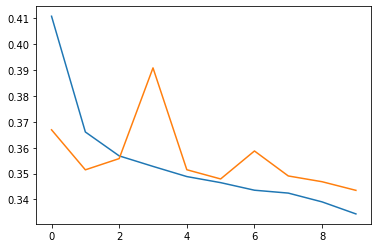

In [101]:
plt.plot(result_train_10_epoch['epoch_train_losses'])
plt.plot(result_train_10_epoch['epoch_valid_losses'])

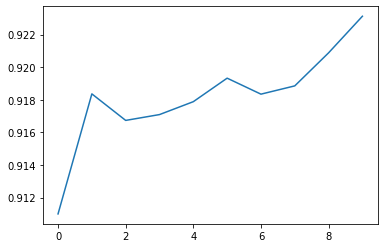

In [102]:
plt.plot(result_train_10_epoch['epoch_valid_metrics'])

In [58]:
y_true, y_proba = test_result(model, test_data_loader)

{'test_loss': 0.3415502811999573, 'test_metric': 0.923768188098981}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


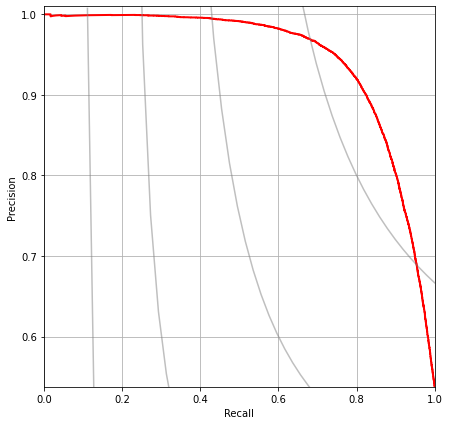

In [66]:
plot_precision_recall(y_true, y_proba)

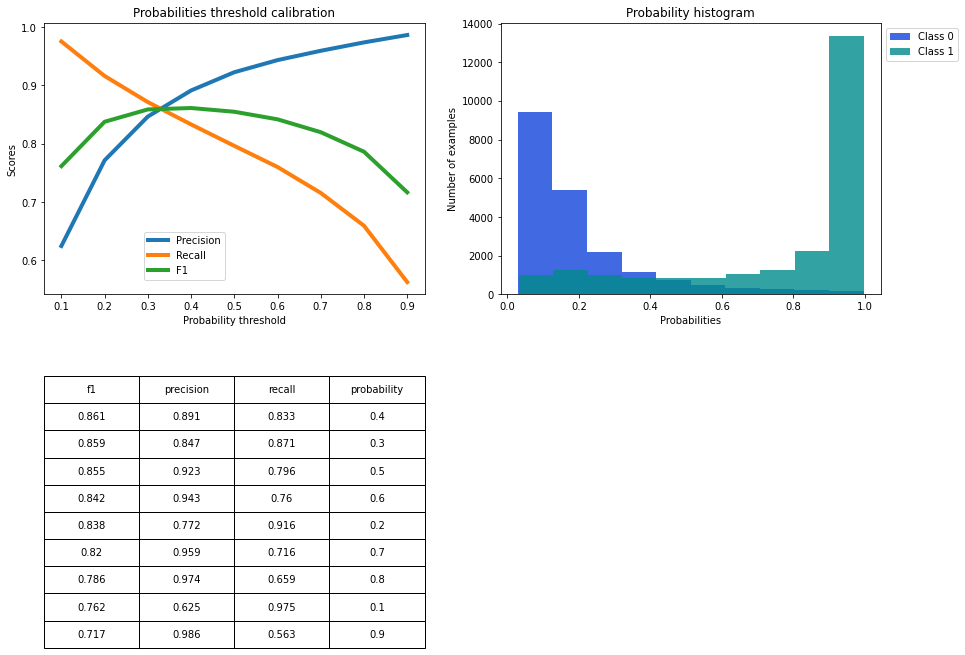

In [67]:
show_proba_calibration_plots(y_proba, y_true)

In [76]:
report(y_true, y_proba, 0.4)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     20455
           1       0.89      0.83      0.86     23779

    accuracy                           0.86     44234
   macro avg       0.86      0.86      0.86     44234
weighted avg       0.86      0.86      0.86     44234

---------------
Матрица ошибок:
[[18040  2415]
 [ 3968 19811]]
---------------
Правильно предсказано 0: 18040
Правильно предсказано 1: 19811
Ложноотрицательных (FN, ош2р, пропуск события): 3968
Ложноположительных (FP, ош1р, ложная  тревога): 2415
Всего ошибок: 6383


# После 15 эпох обучения

In [95]:
result_train = model_wrapper.fit(criterion,
             metric,
             optimizer,
             scheduler,
             train_data_loader,
             valid_data_loader,
             epochs=3,
             verbose=10)

Train Epoch: 1, Loss: 0.358005, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 9)(320 images: 5.212410 sec
Train Epoch: 1, Loss: 0.323419, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 19)(320 images: 4.980867 sec
Train Epoch: 1, Loss: 0.299017, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 29)(320 images: 4.743820 sec
Train Epoch: 1, Loss: 0.348246, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 39)(320 images: 4.787416 sec
Train Epoch: 1, Loss: 0.382653, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 49)(320 images: 4.625921 sec
Train Epoch: 1, Loss: 0.268428, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 59)(320 images: 4.615187 sec
Train Epoch: 1, Loss: 0.308369, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 69)(320 images: 4.666147 sec
Train Epoch: 1, Loss: 0.320580, Learning rate: 0.00270180043831

Train Epoch: 1, Loss: 0.334224, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 619)(320 images: 4.485076 sec
Train Epoch: 1, Loss: 0.279212, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 629)(320 images: 4.608495 sec
Train Epoch: 1, Loss: 0.308513, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 639)(320 images: 4.551252 sec
Train Epoch: 1, Loss: 0.348786, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 649)(320 images: 4.578440 sec
Train Epoch: 1, Loss: 0.327592, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 659)(320 images: 4.830560 sec
Train Epoch: 1, Loss: 0.263951, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 669)(320 images: 4.904308 sec
Train Epoch: 1, Loss: 0.385615, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 679)(320 images: 4.904131 sec
Train Epoch: 1, Loss: 0.310597, Learning rate: 0.002701

Train Epoch: 1, Loss: 0.383103, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1229)(320 images: 4.438513 sec
Train Epoch: 1, Loss: 0.309679, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1239)(320 images: 4.518168 sec
Train Epoch: 1, Loss: 0.321736, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1249)(320 images: 4.940754 sec
Train Epoch: 1, Loss: 0.322949, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1259)(320 images: 4.492988 sec
Train Epoch: 1, Loss: 0.300450, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1269)(320 images: 4.919021 sec
Train Epoch: 1, Loss: 0.296203, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1279)(320 images: 4.898258 sec
Train Epoch: 1, Loss: 0.318385, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1289)(320 images: 4.581001 sec
Train Epoch: 1, Loss: 0.328000, Learning rate: 0

Train Epoch: 1, Loss: 0.300961, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1839)(320 images: 4.445070 sec
Train Epoch: 1, Loss: 0.310194, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1849)(320 images: 4.665301 sec
Train Epoch: 1, Loss: 0.319089, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1859)(320 images: 4.545981 sec
Train Epoch: 1, Loss: 0.310209, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1869)(320 images: 4.461972 sec
Train Epoch: 1, Loss: 0.331218, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1879)(320 images: 4.457149 sec
Train Epoch: 1, Loss: 0.257272, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1889)(320 images: 4.382247 sec
Train Epoch: 1, Loss: 0.333203, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 1899)(320 images: 4.422805 sec
Train Epoch: 1, Loss: 0.335925, Learning rate: 0

Train Epoch: 1, Loss: 0.297389, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 2449)(320 images: 4.505911 sec
Train Epoch: 1, Loss: 0.367107, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 2459)(320 images: 4.625695 sec
Train Epoch: 1, Loss: 0.349532, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 2469)(320 images: 4.552417 sec
Train Epoch: 1, Loss: 0.345172, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 2479)(320 images: 4.611787 sec
Train Epoch: 1, Loss: 0.307089, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 2489)(320 images: 4.410121 sec
Train Epoch: 1, Loss: 0.307279, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 2499)(320 images: 4.532603 sec
Train Epoch: 1, Loss: 0.351208, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 2509)(320 images: 4.566937 sec
Train Epoch: 1, Loss: 0.309294, Learning rate: 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 1, train loss: 0.325950, valid loss: 0.340732, valid metric: 0.922878
Train Epoch: 1, Loss: 0.324185, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3009)(320 images: 82.921270 sec
Train Epoch: 1, Loss: 0.337373, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3019)(320 images: 5.556053 sec
Train Epoch: 1, Loss: 0.344017, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3029)(320 images: 5.606222 sec
Train Epoch: 1, Loss: 0.335886, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3039)(320 images: 5.624943 sec
Train Epoch: 1, Loss: 0.393422, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3049)(320 images: 5.490552 sec
Train Epoch: 1, Loss: 0.332780, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3059)(320 images: 5.310569 sec
Train Epoch: 1, Loss: 0.392733, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 30

Train Epoch: 1, Loss: 0.297075, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3599)(320 images: 5.296231 sec
Train Epoch: 1, Loss: 0.349597, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3609)(320 images: 5.535780 sec
Train Epoch: 1, Loss: 0.314293, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3619)(320 images: 5.405215 sec
Train Epoch: 1, Loss: 0.327023, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3629)(320 images: 5.716264 sec
Train Epoch: 1, Loss: 0.420168, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3639)(320 images: 5.474455 sec
Train Epoch: 1, Loss: 0.348963, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3649)(320 images: 5.513621 sec
Train Epoch: 1, Loss: 0.294865, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 3659)(320 images: 5.672230 sec
Train Epoch: 1, Loss: 0.369405, Learning rate: 0

Train Epoch: 1, Loss: 0.309036, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4209)(320 images: 5.512587 sec
Train Epoch: 1, Loss: 0.303550, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4219)(320 images: 5.528467 sec
Train Epoch: 1, Loss: 0.298104, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4229)(320 images: 5.264771 sec
Train Epoch: 1, Loss: 0.284410, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4239)(320 images: 5.246183 sec
Train Epoch: 1, Loss: 0.380490, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4249)(320 images: 5.373874 sec
Train Epoch: 1, Loss: 0.335283, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4259)(320 images: 5.516774 sec
Train Epoch: 1, Loss: 0.331704, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4269)(320 images: 5.564966 sec
Train Epoch: 1, Loss: 0.302938, Learning rate: 0

Train Epoch: 1, Loss: 0.374210, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4819)(320 images: 4.466611 sec
Train Epoch: 1, Loss: 0.349242, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4829)(320 images: 4.538000 sec
Train Epoch: 1, Loss: 0.350069, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4839)(320 images: 4.379752 sec
Train Epoch: 1, Loss: 0.310398, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4849)(320 images: 4.317625 sec
Train Epoch: 1, Loss: 0.357976, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4859)(320 images: 4.465149 sec
Train Epoch: 1, Loss: 0.330409, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4869)(320 images: 4.456755 sec
Train Epoch: 1, Loss: 0.316495, Learning rate: 0.0027018004383131834
Spended time for 10 batches (total: 4879)(320 images: 4.414513 sec
Train Epoch: 1, Loss: 0.341031, Learning rate: 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 2, Loss: 0.314781, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 9)(320 images: 4.579697 sec
Train Epoch: 2, Loss: 0.282988, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 19)(320 images: 4.502675 sec
Train Epoch: 2, Loss: 0.379956, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 29)(320 images: 4.590887 sec
Train Epoch: 2, Loss: 0.304181, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 39)(320 images: 4.572819 sec
Train Epoch: 2, Loss: 0.355835, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 49)(320 images: 4.584819 sec
Train Epoch: 2, Loss: 0.333841, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 59)(320 images: 4.729267 sec
Train Epoch: 2, Loss: 0.334652, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 69)(320 images: 4.664423 sec
Train Epoch: 2, Loss: 0.350171, Learning rate: 0.002566710416397524
Sp

Train Epoch: 2, Loss: 0.321841, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 629)(320 images: 4.687017 sec
Train Epoch: 2, Loss: 0.329511, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 639)(320 images: 4.668961 sec
Train Epoch: 2, Loss: 0.306016, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 649)(320 images: 4.837708 sec
Train Epoch: 2, Loss: 0.292984, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 659)(320 images: 4.763716 sec
Train Epoch: 2, Loss: 0.312966, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 669)(320 images: 4.735323 sec
Train Epoch: 2, Loss: 0.279261, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 679)(320 images: 4.638640 sec
Train Epoch: 2, Loss: 0.398896, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 689)(320 images: 4.712880 sec
Train Epoch: 2, Loss: 0.335769, Learning rate: 0.0025667104163

Train Epoch: 2, Loss: 0.332274, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1239)(320 images: 4.539724 sec
Train Epoch: 2, Loss: 0.268183, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1249)(320 images: 4.517698 sec
Train Epoch: 2, Loss: 0.350241, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1259)(320 images: 4.523986 sec
Train Epoch: 2, Loss: 0.312329, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1269)(320 images: 4.603581 sec
Train Epoch: 2, Loss: 0.292101, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1279)(320 images: 4.607842 sec
Train Epoch: 2, Loss: 0.316326, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1289)(320 images: 4.580264 sec
Train Epoch: 2, Loss: 0.341829, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1299)(320 images: 4.549045 sec
Train Epoch: 2, Loss: 0.319163, Learning rate: 0.002566

Train Epoch: 2, Loss: 0.313804, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1849)(320 images: 4.426610 sec
Train Epoch: 2, Loss: 0.381976, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1859)(320 images: 4.461560 sec
Train Epoch: 2, Loss: 0.357104, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1869)(320 images: 4.337255 sec
Train Epoch: 2, Loss: 0.320224, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1879)(320 images: 4.381687 sec
Train Epoch: 2, Loss: 0.309112, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1889)(320 images: 4.510934 sec
Train Epoch: 2, Loss: 0.301244, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1899)(320 images: 4.458145 sec
Train Epoch: 2, Loss: 0.314061, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 1909)(320 images: 4.559298 sec
Train Epoch: 2, Loss: 0.407152, Learning rate: 0.002566

Train Epoch: 2, Loss: 0.302491, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 2459)(320 images: 4.595090 sec
Train Epoch: 2, Loss: 0.278682, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 2469)(320 images: 4.474294 sec
Train Epoch: 2, Loss: 0.340578, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 2479)(320 images: 4.515331 sec
Train Epoch: 2, Loss: 0.344753, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 2489)(320 images: 4.552378 sec
Train Epoch: 2, Loss: 0.321276, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 2499)(320 images: 4.450063 sec
Train Epoch: 2, Loss: 0.320673, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 2509)(320 images: 4.535123 sec
Train Epoch: 2, Loss: 0.332524, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 2519)(320 images: 4.516359 sec
Train Epoch: 2, Loss: 0.298181, Learning rate: 0.002566

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 2, train loss: 0.324571, valid loss: 0.350690, valid metric: 0.921980
Train Epoch: 2, Loss: 0.311707, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3009)(320 images: 65.540608 sec
Train Epoch: 2, Loss: 0.297913, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3019)(320 images: 4.572055 sec
Train Epoch: 2, Loss: 0.317711, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3029)(320 images: 4.592775 sec
Train Epoch: 2, Loss: 0.308528, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3039)(320 images: 4.596956 sec
Train Epoch: 2, Loss: 0.371853, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3049)(320 images: 4.602324 sec
Train Epoch: 2, Loss: 0.344574, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3059)(320 images: 4.576065 sec
Train Epoch: 2, Loss: 0.305613, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3069)(320

Train Epoch: 2, Loss: 0.316252, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3599)(320 images: 4.558252 sec
Train Epoch: 2, Loss: 0.370560, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3609)(320 images: 4.537374 sec
Train Epoch: 2, Loss: 0.245508, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3619)(320 images: 4.392310 sec
Train Epoch: 2, Loss: 0.344887, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3629)(320 images: 4.379944 sec
Train Epoch: 2, Loss: 0.261804, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3639)(320 images: 4.318700 sec
Train Epoch: 2, Loss: 0.301033, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3649)(320 images: 4.586915 sec
Train Epoch: 2, Loss: 0.275551, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 3659)(320 images: 4.341222 sec
Train Epoch: 2, Loss: 0.361322, Learning rate: 0.002566

Train Epoch: 2, Loss: 0.308901, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4209)(320 images: 4.535884 sec
Train Epoch: 2, Loss: 0.325943, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4219)(320 images: 4.628348 sec
Train Epoch: 2, Loss: 0.341731, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4229)(320 images: 4.610200 sec
Train Epoch: 2, Loss: 0.298509, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4239)(320 images: 4.618086 sec
Train Epoch: 2, Loss: 0.341603, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4249)(320 images: 4.571857 sec
Train Epoch: 2, Loss: 0.330688, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4259)(320 images: 4.555267 sec
Train Epoch: 2, Loss: 0.331886, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4269)(320 images: 4.449058 sec
Train Epoch: 2, Loss: 0.380307, Learning rate: 0.002566

Train Epoch: 2, Loss: 0.339070, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4819)(320 images: 5.283839 sec
Train Epoch: 2, Loss: 0.316513, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4829)(320 images: 5.257310 sec
Train Epoch: 2, Loss: 0.294329, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4839)(320 images: 5.530393 sec
Train Epoch: 2, Loss: 0.283248, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4849)(320 images: 5.508509 sec
Train Epoch: 2, Loss: 0.374428, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4859)(320 images: 5.519457 sec
Train Epoch: 2, Loss: 0.304985, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4869)(320 images: 5.563588 sec
Train Epoch: 2, Loss: 0.316232, Learning rate: 0.002566710416397524
Spended time for 10 batches (total: 4879)(320 images: 5.546222 sec
Train Epoch: 2, Loss: 0.339097, Learning rate: 0.002566

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train Epoch: 3, Loss: 0.346216, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 9)(320 images: 4.667004 sec
Train Epoch: 3, Loss: 0.344222, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 19)(320 images: 4.402952 sec
Train Epoch: 3, Loss: 0.322532, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 29)(320 images: 4.474953 sec
Train Epoch: 3, Loss: 0.276174, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 39)(320 images: 4.453793 sec
Train Epoch: 3, Loss: 0.329640, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 49)(320 images: 4.467244 sec
Train Epoch: 3, Loss: 0.352489, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 59)(320 images: 4.447927 sec
Train Epoch: 3, Loss: 0.324816, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 69)(320 images: 4.448517 sec
Train Epoch: 3, Loss: 0.290031, Learning rate: 0.00243837489557

Train Epoch: 3, Loss: 0.319272, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 619)(320 images: 4.363028 sec
Train Epoch: 3, Loss: 0.314183, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 629)(320 images: 4.374748 sec
Train Epoch: 3, Loss: 0.288059, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 639)(320 images: 4.225299 sec
Train Epoch: 3, Loss: 0.255455, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 649)(320 images: 4.309313 sec
Train Epoch: 3, Loss: 0.346907, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 659)(320 images: 4.470842 sec
Train Epoch: 3, Loss: 0.309038, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 669)(320 images: 4.318287 sec
Train Epoch: 3, Loss: 0.328169, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 679)(320 images: 4.591528 sec
Train Epoch: 3, Loss: 0.280174, Learning rate: 0.002438

Train Epoch: 3, Loss: 0.293224, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1229)(320 images: 4.483939 sec
Train Epoch: 3, Loss: 0.286795, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1239)(320 images: 4.401149 sec
Train Epoch: 3, Loss: 0.364408, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1249)(320 images: 4.470232 sec
Train Epoch: 3, Loss: 0.289951, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1259)(320 images: 4.411452 sec
Train Epoch: 3, Loss: 0.323672, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1269)(320 images: 4.480354 sec
Train Epoch: 3, Loss: 0.298759, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1279)(320 images: 4.363433 sec
Train Epoch: 3, Loss: 0.295948, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1289)(320 images: 4.412104 sec
Train Epoch: 3, Loss: 0.312237, Learning rate: 0

Train Epoch: 3, Loss: 0.328408, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1839)(320 images: 4.344555 sec
Train Epoch: 3, Loss: 0.358694, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1849)(320 images: 4.355271 sec
Train Epoch: 3, Loss: 0.340331, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1859)(320 images: 4.379026 sec
Train Epoch: 3, Loss: 0.337243, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1869)(320 images: 4.388050 sec
Train Epoch: 3, Loss: 0.330324, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1879)(320 images: 4.418117 sec
Train Epoch: 3, Loss: 0.320987, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1889)(320 images: 4.415494 sec
Train Epoch: 3, Loss: 0.367907, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 1899)(320 images: 4.417768 sec
Train Epoch: 3, Loss: 0.354067, Learning rate: 0

Train Epoch: 3, Loss: 0.283274, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 2449)(320 images: 4.264941 sec
Train Epoch: 3, Loss: 0.310791, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 2459)(320 images: 4.303668 sec
Train Epoch: 3, Loss: 0.338981, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 2469)(320 images: 4.312648 sec
Train Epoch: 3, Loss: 0.334431, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 2479)(320 images: 4.319592 sec
Train Epoch: 3, Loss: 0.331994, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 2489)(320 images: 4.277369 sec
Train Epoch: 3, Loss: 0.302324, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 2499)(320 images: 4.320656 sec
Train Epoch: 3, Loss: 0.353704, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 2509)(320 images: 4.292792 sec
Train Epoch: 3, Loss: 0.273610, Learning rate: 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 3, train loss: 0.320249, valid loss: 0.335155, valid metric: 0.925048
Train Epoch: 3, Loss: 0.324947, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3009)(320 images: 81.757803 sec
Train Epoch: 3, Loss: 0.277984, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3019)(320 images: 5.304645 sec
Train Epoch: 3, Loss: 0.338322, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3029)(320 images: 5.309877 sec
Train Epoch: 3, Loss: 0.300780, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3039)(320 images: 5.411035 sec
Train Epoch: 3, Loss: 0.290861, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3049)(320 images: 5.351526 sec
Train Epoch: 3, Loss: 0.333092, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3059)(320 images: 5.285333 sec
Train Epoch: 3, Loss: 0.355154, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 30

Train Epoch: 3, Loss: 0.290088, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3599)(320 images: 4.305450 sec
Train Epoch: 3, Loss: 0.313031, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3609)(320 images: 4.365380 sec
Train Epoch: 3, Loss: 0.273958, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3619)(320 images: 4.223298 sec
Train Epoch: 3, Loss: 0.288361, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3629)(320 images: 4.398769 sec
Train Epoch: 3, Loss: 0.324736, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3639)(320 images: 4.292636 sec
Train Epoch: 3, Loss: 0.349628, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3649)(320 images: 4.286110 sec
Train Epoch: 3, Loss: 0.339757, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 3659)(320 images: 4.210926 sec
Train Epoch: 3, Loss: 0.344197, Learning rate: 0

Train Epoch: 3, Loss: 0.311302, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4209)(320 images: 4.378390 sec
Train Epoch: 3, Loss: 0.335422, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4219)(320 images: 4.320701 sec
Train Epoch: 3, Loss: 0.277939, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4229)(320 images: 4.321331 sec
Train Epoch: 3, Loss: 0.298033, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4239)(320 images: 4.351566 sec
Train Epoch: 3, Loss: 0.318602, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4249)(320 images: 4.412587 sec
Train Epoch: 3, Loss: 0.314027, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4259)(320 images: 4.443890 sec
Train Epoch: 3, Loss: 0.335367, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4269)(320 images: 4.169481 sec
Train Epoch: 3, Loss: 0.337835, Learning rate: 0

Train Epoch: 3, Loss: 0.291982, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4819)(320 images: 4.146231 sec
Train Epoch: 3, Loss: 0.306262, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4829)(320 images: 4.119181 sec
Train Epoch: 3, Loss: 0.294864, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4839)(320 images: 4.136834 sec
Train Epoch: 3, Loss: 0.358602, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4849)(320 images: 4.174508 sec
Train Epoch: 3, Loss: 0.327274, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4859)(320 images: 4.140188 sec
Train Epoch: 3, Loss: 0.319810, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4869)(320 images: 4.777163 sec
Train Epoch: 3, Loss: 0.317974, Learning rate: 0.0024383748955776477
Spended time for 10 batches (total: 4879)(320 images: 5.126264 sec
Train Epoch: 3, Loss: 0.327876, Learning rate: 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [105]:
model_wrapper.save('/Users/igorfrolkin/Downloads/vad_model2_2.pth')

In [96]:
result_train_15_epoch = result_train.copy()

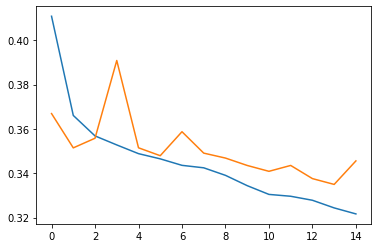

In [98]:
plt.plot(result_train_10_epoch['epoch_train_losses'] + result_train_12_epoch['epoch_train_losses'] + result_train['epoch_train_losses'])
plt.plot(result_train_10_epoch['epoch_valid_losses'] + result_train_12_epoch['epoch_valid_losses'] + result_train['epoch_valid_losses'])

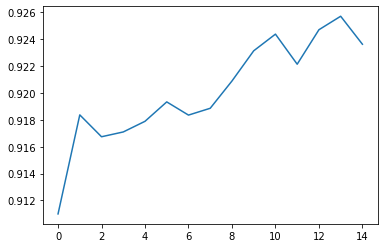

In [99]:
plt.plot(result_train_10_epoch['epoch_valid_metrics'] + result_train_12_epoch['epoch_valid_metrics'] + result_train['epoch_valid_metrics'])

In [100]:
y_true, y_proba = test_result(model, test_data_loader)

{'test_loss': 0.34231153279758414, 'test_metric': 0.9246416615463038}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


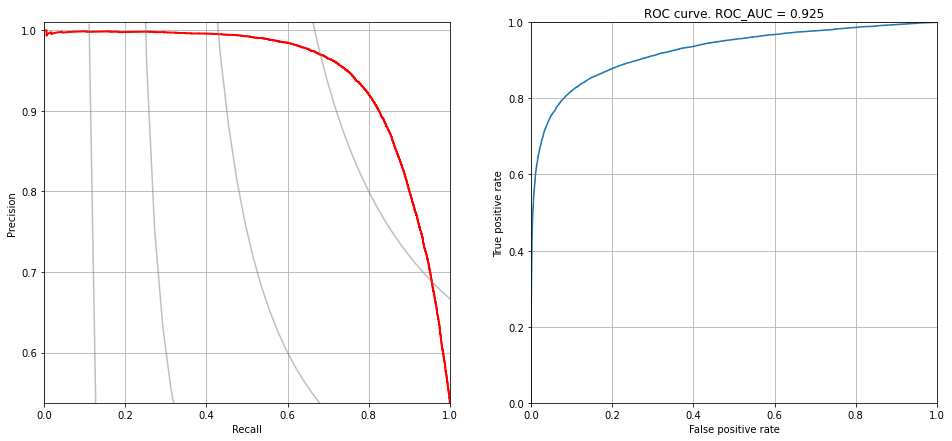

In [124]:
plot_PR_ROC(y_true, y_proba)

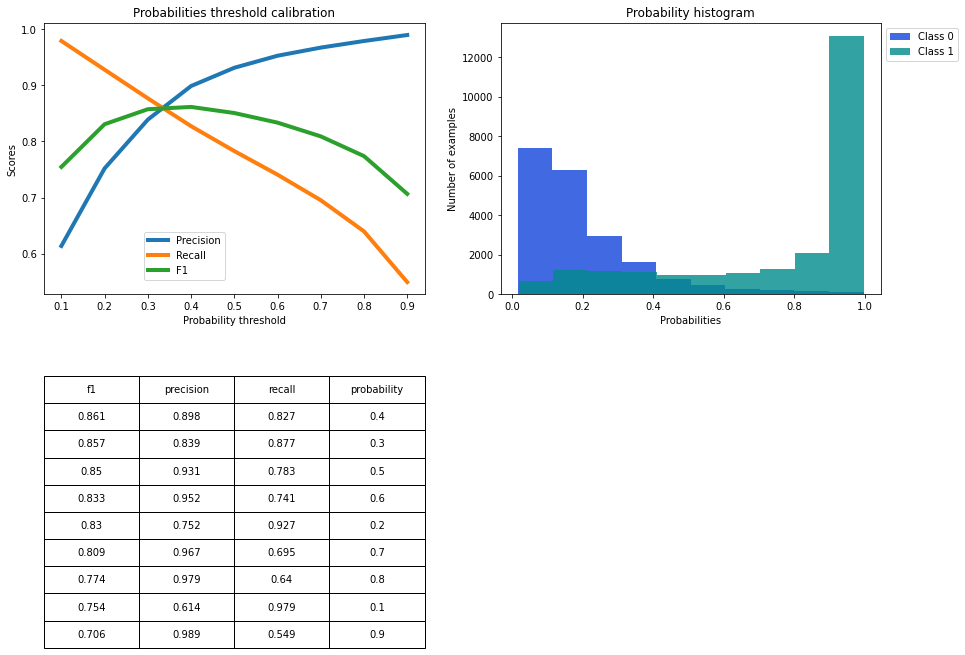

In [104]:
show_proba_calibration_plots(y_proba, y_true)

In [111]:
report(y_true, y_proba, 0.42)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85     20455
           1       0.91      0.82      0.86     23779

    accuracy                           0.86     44234
   macro avg       0.86      0.86      0.86     44234
weighted avg       0.86      0.86      0.86     44234

---------------
Матрица ошибок:
[[18466  1989]
 [ 4341 19438]]
---------------
Правильно предсказано 0: 18466
Правильно предсказано 1: 19438
Ложноотрицательных (FN, ош2р, пропуск события): 4341
Ложноположительных (FP, ош1р, ложная  тревога): 1989
Всего ошибок: 6330
